<h1>PROBLEM STATEMENT </h1>
Happy Customer Bank credit card lead prediction.

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings. The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like telecasting, e-mails, recommendations on net banking, mobile banking, etc. In this case, the Happy Customer Bank wants to cross-sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards. Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card.

# NoteBook Contents

The notebook is devided into three parts.

i)Short-cut  EDA.

ii) Extensive Feature Engineerings.

iii) Model Experimentations and Winning techniques.


<h1>Importing Libraries </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize':(12.0,8.0)})
plt.rcParams.update({'font.size':14})
pd.set_option('display.float_format',lambda x:'%.3f'%x)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
%matplotlib inline
from numpy import exp
from lightgbm import LGBMClassifier
import shap
from scipy.stats import boxcox
plt.style.use("seaborn")
from scipy.stats import kurtosis,skew,kstat
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
train=pd.read_csv('train_s3TEQDk.csv')
test=pd.read_csv('test_mSzZ8RL.csv')

In [3]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [5]:
train.shape,test.shape

((245725, 11), (105312, 10))

In [6]:
def basic_info(df):
    '''checking basic information & shape about the dataframe'''
    temp=df.copy(deep=True)
    print("Shape of the dataset",df.shape)
    print("*"*30)
    print(df.info())
    
basic_info(train)

Shape of the dataset (245725, 11)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
None


- As we can see, we have missing values in the Credit_Product column.

In [7]:
basic_info(test)

Shape of the dataset (105312, 10)
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB
None


In [8]:
def check_missing_values(df):
    '''Function to check the missing data percentage'''
    print("percentage of missing data of dataframe \n",df.isnull().sum()/len(df)*100)
    
check_missing_values(train)
print("*"*60)
check_missing_values(test)

percentage of missing data of dataframe 
 ID                     0.000
Gender                 0.000
Age                    0.000
Region_Code            0.000
Occupation             0.000
Channel_Code           0.000
Vintage                0.000
Credit_Product        11.934
Avg_Account_Balance    0.000
Is_Active              0.000
Is_Lead                0.000
dtype: float64
************************************************************
percentage of missing data of dataframe 
 ID                     0.000
Gender                 0.000
Age                    0.000
Region_Code            0.000
Occupation             0.000
Channel_Code           0.000
Vintage                0.000
Credit_Product        11.890
Avg_Account_Balance    0.000
Is_Active              0.000
dtype: float64


- In both the train and test data we have missing values of 11%. We will impute it simply with most occured lable of the respective column.

In [9]:
def check_duplicate(df):
    duplicate=df[df.duplicated()]
    return duplicate

duplicate=check_duplicate(train)
duplicate

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead


In [10]:
def check_duplicate(df):
    duplicate=df[df.duplicated()]
    return duplicate

duplicate=check_duplicate(test)
duplicate

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active


- As we can see, There are no duplicate rows in the column.

<h1>Missing Value Imputation for (Credit_Product)</h1>

- Replacing missing values of Credit_Product column with the most frequent values.

In [12]:
train['Credit_Product'].fillna(value="Yes",inplace=True)
temp=test['Credit_Product'].value_counts().index[0]
test['Credit_Product'].fillna(value="Yes",inplace=True)


<h1> EDA </h1>

In [13]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000,245725.000,245725.000,245725.000
mean,43.856,46.959,1128403.101,0.237
std,14.829,32.353,852936.356,0.425
min,23.000,7.000,20790.000,0.000
25%,30.000,20.000,604310.000,0.000
50%,43.000,32.000,894601.000,0.000
75%,54.000,73.000,1366666.000,0.000
max,85.000,135.000,10352009.000,1.000


- Too much difference between the max value and 75% value of the AVg_Account_Balance.

In [14]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000,105312.000,105312.000
mean,43.871,46.843,1134194.631
std,14.873,32.274,866242.989
min,24.000,7.000,22597.000
25%,30.000,20.000,603982.250
50%,43.000,32.000,896634.500
75%,54.000,73.000,1371598.250
max,85.000,135.000,9908858.000


In [15]:
train.corr()

,Age,Vintage,Avg_Account_Balance,Is_Lead
Age,1.000,0.631,0.145,0.231
Vintage,0.631,1.000,0.167,0.280
Avg_Account_Balance,0.145,0.167,1.000,0.053
Is_Lead,0.231,0.280,0.053,1.000


- No excessive corrleations in train data.

In [16]:
test.corr()

,Age,Vintage,Avg_Account_Balance
Age,1.000,0.622,0.136
Vintage,0.622,1.000,0.165
Avg_Account_Balance,0.136,0.165,1.000


- No excessive correlation on the test data also.

<h1>Univariate Analysis </h1>

<h2>AVG_Account_Balance</h1>

In [17]:
train['Avg_Account_Balance'].describe()

count     245725.000
mean     1128403.101
std       852936.356
min        20790.000
25%       604310.000
50%       894601.000
75%      1366666.000
max     10352009.000
Name: Avg_Account_Balance, dtype: float64

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


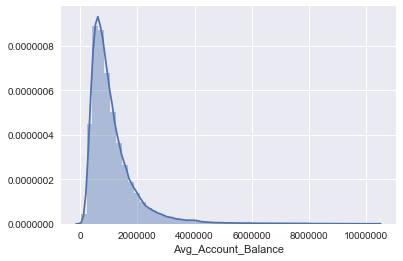

In [18]:
sns.distplot(train['Avg_Account_Balance'])
plt.ticklabel_format(style = 'plain')

- Looking like a skewed data.
- Most of the customers avg account balance is coming between 0-40000000

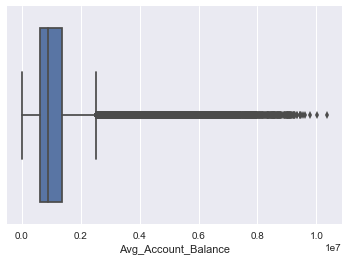

In [19]:
sns.boxplot(train['Avg_Account_Balance'])

In [20]:
train=train[train['Avg_Account_Balance']<=max(test.Avg_Account_Balance)].reset_index(drop=True)

<h1>Bivariate Analysis of Avg_Account Balance </h1>

In [21]:
train.groupby('Gender')['Avg_Account_Balance'].mean()

Gender
Female   1107373.189
Male     1145745.932
Name: Avg_Account_Balance, dtype: float64

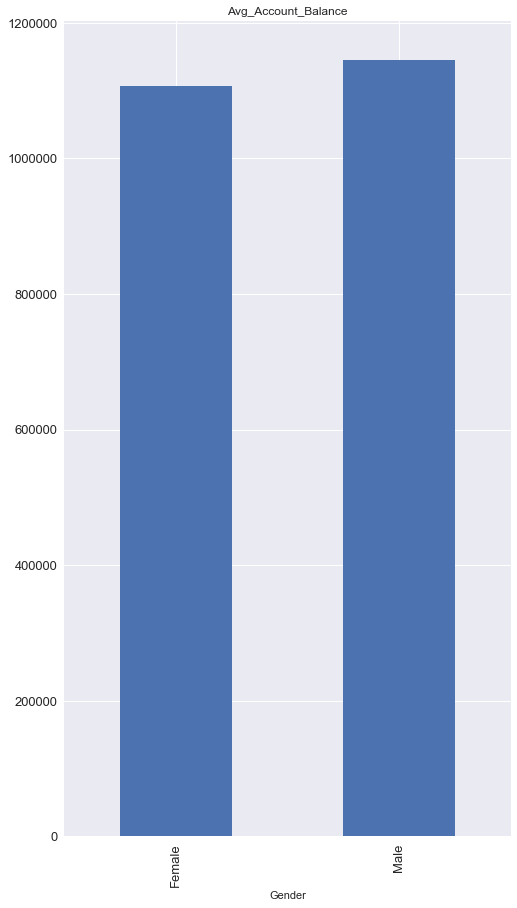

In [22]:
train.groupby('Gender')['Avg_Account_Balance'].mean().plot(kind = "bar", subplots = True, figsize = (8,15), fontsize = 13)
plt.show()

- None of the label is dominating which is a good thing.

In [22]:
train.groupby('Occupation')['Avg_Account_Balance'].mean()

Occupation
Entrepreneur    1411819.899
Other           1209739.562
Salaried        1033419.713
Self_Employed   1131946.454
Name: Avg_Account_Balance, dtype: float64

- As we can see, Entrepreneur has got highest account balance which is an obvious thing.

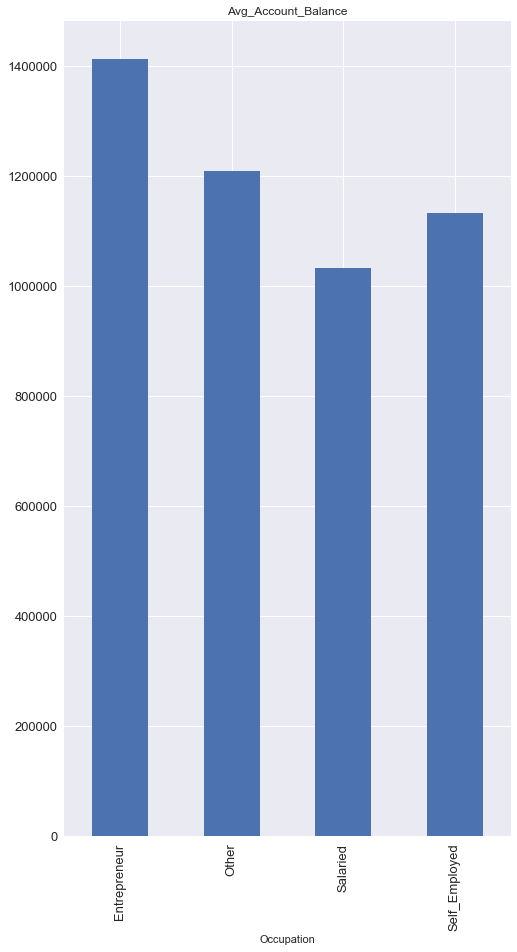

In [23]:
train.groupby('Occupation')['Avg_Account_Balance'].mean().plot(kind = "bar", subplots = True, figsize = (8,15), fontsize = 13)
plt.show()

In [24]:
train.groupby('Channel_Code')['Avg_Account_Balance'].mean()

Channel_Code
X1   1030331.438
X2   1142456.649
X3   1274624.205
X4    976635.630
Name: Avg_Account_Balance, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018061608DD8>],
      dtype=object)

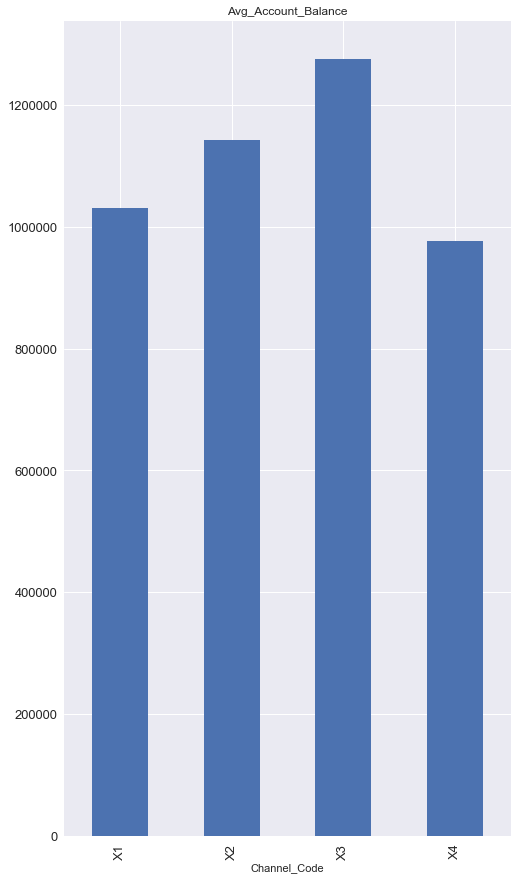

In [25]:
train.groupby('Channel_Code')['Avg_Account_Balance'].mean().plot(kind = "bar", subplots = True, figsize = (8,15), fontsize = 13)

- Channel_Code X3 has highest account balance.Hence It may happen entrepreneurs are coming through channel code 3.

In [26]:
train.groupby('Region_Code')['Avg_Account_Balance'].mean()

Region_Code
RG250    735763.976
RG251    741677.953
RG252    634770.713
RG253   1374248.054
RG254   1407392.135
RG255    868249.743
RG256    674806.832
RG257    858105.454
RG258    705005.030
RG259    625180.415
RG260    758465.153
RG261    981286.400
RG262   1200158.046
RG263    831138.975
RG264    674554.011
RG265    805709.646
RG266    696652.228
RG267    682724.526
RG268   1463652.729
RG269   1027003.152
RG270    698456.727
RG271    744592.654
RG272    885223.502
RG273    856303.292
RG274    996307.055
RG275    855062.043
RG276   1059816.651
RG277    983289.347
RG278    913786.078
RG279    714573.902
RG280    782956.341
RG281    889643.698
RG282    953867.706
RG283   1475284.235
RG284   1473165.568
Name: Avg_Account_Balance, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001806166A240>],
      dtype=object)

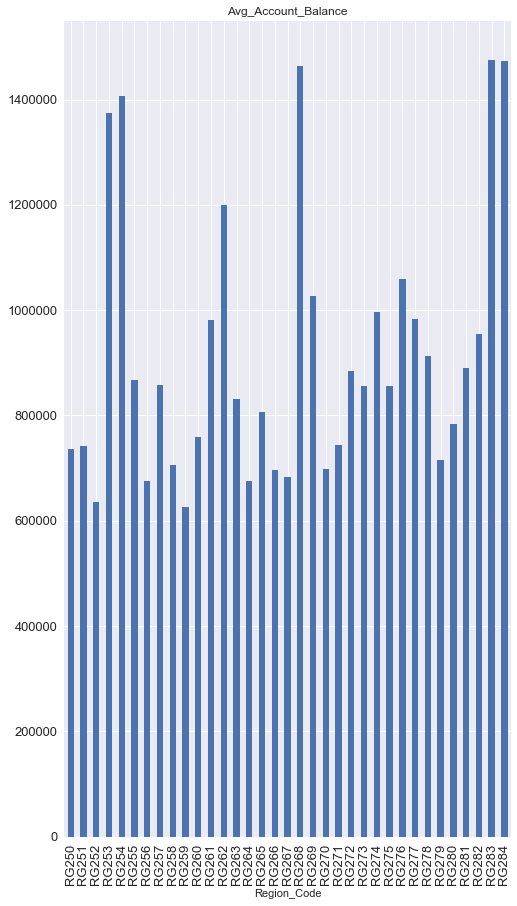

In [27]:
train.groupby('Region_Code')['Avg_Account_Balance'].mean().plot(kind = "bar", subplots = True, figsize = (8,15), fontsize = 13)

In [28]:
train.loc[train['Region_Code']=='RG283']['Occupation'].value_counts()

Self_Employed    14362
Other             9462
Salaried          4992
Entrepreneur       599
Name: Occupation, dtype: int64

- As entrepreneurs are present in the RG283,We can see,spikes in the RG283,RG284 regions.

In [29]:
train.loc[train['Region_Code']=='RG284']['Occupation'].value_counts()

Self_Employed    9422
Other            6164
Salaried         3352
Entrepreneur      382
Name: Occupation, dtype: int64

- In both Region 283,284 entrepreneurs numbers are highest.

In [28]:
train.loc[train['Region_Code']=='RG258']['Occupation'].value_counts()

Self_Employed    767
Salaried         683
Other            487
Entrepreneur      14
Name: Occupation, dtype: int64

- RG258 has less number of entrepreneurs. 

In [31]:
train.loc[train['Region_Code']=='RG253']['Occupation'].value_counts()

Self_Employed    960
Other            514
Salaried         369
Entrepreneur      15
Name: Occupation, dtype: int64

In [32]:
train.loc[train['Region_Code']=='RG250']['Occupation'].value_counts()

Salaried         1093
Self_Employed     748
Other             648
Entrepreneur        7
Name: Occupation, dtype: int64

In [33]:
train.loc[train['Region_Code']=='RG259']['Occupation'].value_counts()

Salaried         1080
Self_Employed     866
Other             623
Entrepreneur       17
Name: Occupation, dtype: int64

- In regions 252,259 regions ,salary employed are highest.

In [34]:
train.groupby('Credit_Product')['Avg_Account_Balance'].mean()

Credit_Product
No    1078017.798
Yes   1199979.056
Name: Avg_Account_Balance, dtype: float64

- After analysing the above graphs we can say, entrepreneurs are influencing the account balance in region and channel codes.

<h1>Creation of Groupwise Feature for Avg_Account_Balance (Train Data)</h1>

<h1>Statistical Feature </h1>

- Here we will try to experiement with various of statistical feature.

  i)We will take all the categorical variables and invent some basic statistical features.
  
  ii) Statistical Features Include(Mean,Skewness,Kurtosis,Kstats.)

<h1>Mean Feature </h1>

In [29]:
train['Gender_Avg_Income_mean']=train.groupby('Gender').Avg_Account_Balance.transform("mean")
train['Occupation_Avg_Income_mean']=train.groupby('Occupation').Avg_Account_Balance.transform("mean")
train['Region_Code_Avg_Income_mean']=train.groupby('Region_Code').Avg_Account_Balance.transform("mean")
train['Channel_Code_Avg_Income_mean']=train.groupby('Channel_Code').Avg_Account_Balance.transform("mean")
train['Credit_product_Avg_Income_mean']=train.groupby('Credit_Product').Avg_Account_Balance.transform("mean")
train['Is_Active_Avg_Income_mean']=train.groupby('Is_Active').Avg_Account_Balance.transform("mean")


<h1>Skewness Feature </h1>

In [30]:
train['Gender_Avg_Income_skew']=train.groupby('Gender').Avg_Account_Balance.transform(lambda x:skew(x))
train['Occupation_Avg_Income_skew']=train.groupby('Occupation').Avg_Account_Balance.transform(lambda x:skew(x))
train['Region_Code_Avg_Income_skew']=train.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:skew(x))
train['Channel_Code_Avg_Income_skew']=train.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:skew(x))
train['Credit_product_Avg_Income_skew']=train.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: skew(x))
train['Is_Active_Avg_Income_skew']=train.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: skew(x))

<h1>Kurtosis Feature </h1>

In [31]:
train['Gender_Avg_Income_kur']=train.groupby('Gender').Avg_Account_Balance.transform(lambda x:kurtosis(x))
train['Occupation_Avg_Income_kur']=train.groupby('Occupation').Avg_Account_Balance.transform(lambda x:kurtosis(x))
train['Region_Code_Avg_Income_kur']=train.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:kurtosis(x))
train['Channel_Code_Avg_Income_kur']=train.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:kurtosis(x))
train['Credit_product_Avg_Income_kur']=train.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: kurtosis(x))
train['Is_Active_Avg_Income_kur']=train.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: kurtosis(x))


<h1>Kstat Feature </h1>

In [32]:
train['Gender_Avg_Income_kstat']=train.groupby('Gender').Avg_Account_Balance.transform(lambda x:kstat(x))
train['Occupation_Avg_Income_kstat']=train.groupby('Occupation').Avg_Account_Balance.transform(lambda x:kstat(x))
train['Region_Code_Avg_Income_kstat']=train.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:kstat(x))
train['Channel_Code_Avg_Income_kstat']=train.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:kstat(x))
train['Credit_product_Avg_Income_kstat']=train.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: kstat(x))
train['Is_Active_Avg_Income_kstat']=train.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: kstat(x))

<h1>All the respective feature for the Test data Avg_column.</h1>

In [33]:
test['Gender_Avg_Income_mean']=test.groupby('Gender').Avg_Account_Balance.transform("mean")
test['Occupation_Avg_Income_mean']=test.groupby('Occupation').Avg_Account_Balance.transform("mean")
test['Region_Code_Avg_Income_mean']=test.groupby('Region_Code').Avg_Account_Balance.transform("mean")
test['Channel_Code_Avg_Income_mean']=test.groupby('Channel_Code').Avg_Account_Balance.transform("mean")
test['Credit_product_Avg_Income_mean']=test.groupby('Credit_Product').Avg_Account_Balance.transform("mean")
test['Is_Active_Avg_Income_mean']=test.groupby('Is_Active').Avg_Account_Balance.transform("mean")


In [34]:
test['Gender_Avg_Income_skew']=test.groupby('Gender').Avg_Account_Balance.transform(lambda x:skew(x))
test['Occupation_Avg_Income_skew']=test.groupby('Occupation').Avg_Account_Balance.transform(lambda x:skew(x))
test['Region_Code_Avg_Income_skew']=test.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:skew(x))
test['Channel_Code_Avg_Income_skew']=test.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:skew(x))
test['Credit_product_Avg_Income_skew']=test.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: skew(x))
test['Is_Active_Avg_Income_skew']=test.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: skew(x))

In [35]:
test['Gender_Avg_Income_kur']=test.groupby('Gender').Avg_Account_Balance.transform(lambda x:kurtosis(x))
test['Occupation_Avg_Income_kur']=test.groupby('Occupation').Avg_Account_Balance.transform(lambda x:kurtosis(x))
test['Region_Code_Avg_Income_kur']=test.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:kurtosis(x))
test['Channel_Code_Avg_Income_kur']=test.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:kurtosis(x))
test['Credit_product_Avg_Income_kur']=test.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: kurtosis(x))
test['Is_Active_Avg_Income_kur']=test.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: kurtosis(x))


In [36]:
test['Gender_Avg_Income_kstat']=test.groupby('Gender').Avg_Account_Balance.transform(lambda x:kstat(x))
test['Occupation_Avg_Income_kstat']=test.groupby('Occupation').Avg_Account_Balance.transform(lambda x:kstat(x))
test['Region_Code_Avg_Income_kstat']=test.groupby('Region_Code').Avg_Account_Balance.transform(lambda x:kstat(x))
test['Channel_Code_Avg_Income_kstat']=test.groupby('Channel_Code').Avg_Account_Balance.transform(lambda x:kstat(x))
test['Credit_product_Avg_Income_kstat']=test.groupby('Credit_Product').Avg_Account_Balance.transform(lambda x: kstat(x))
test['Is_Active_Avg_Income_kstat']=test.groupby('Is_Active').Avg_Account_Balance.transform(lambda x: kstat(x))

In [37]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Region_Code_Avg_Income_kur,Channel_Code_Avg_Income_kur,Credit_product_Avg_Income_kur,Is_Active_Avg_Income_kur,Gender_Avg_Income_kstat,Occupation_Avg_Income_kstat,Region_Code_Avg_Income_kstat,Channel_Code_Avg_Income_kstat,Credit_product_Avg_Income_kstat,Is_Active_Avg_Income_kstat
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,9.487,10.958,15.293,15.759,716229939294.158,823730919323.157,1012167416326.024,836703688352.988,699355841370.932,660819916343.596
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,22.847,17.652,15.293,15.759,716229939294.158,643551549434.137,510813915328.562,649634804589.203,699355841370.932,660819916343.596
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,9.487,10.958,15.293,12.409,716229939294.158,699810476123.769,1012167416326.024,836703688352.988,699355841370.932,819818737333.601
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,25.725,17.652,15.293,15.759,734993634448.822,643551549434.137,159209542597.722,649634804589.203,699355841370.932,660819916343.596
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,12.064,17.652,15.293,15.759,716229939294.158,643551549434.137,265581215862.963,649634804589.203,699355841370.932,660819916343.596


In [38]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Region_Code_Avg_Income_kur,Channel_Code_Avg_Income_kur,Credit_product_Avg_Income_kur,Is_Active_Avg_Income_kur,Gender_Avg_Income_kstat,Occupation_Avg_Income_kstat,Region_Code_Avg_Income_kstat,Channel_Code_Avg_Income_kstat,Credit_product_Avg_Income_kstat,Is_Active_Avg_Income_kstat
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,11.442,17.630,13.185,15.919,769724490171.507,848162453393.957,987661656534.684,682851733340.589,763188374187.980,680923239021.016
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,9.178,13.529,13.185,15.919,769724490171.507,848162453393.957,1073873102665.338,693499978078.187,763188374187.980,680923239021.016
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,13.836,17.630,15.599,15.919,769724490171.507,692831453747.548,148591729072.457,682851733340.589,736263317005.342,680923239021.016
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,40.831,17.630,15.599,15.919,769724490171.507,848162453393.957,359986768939.788,682851733340.589,736263317005.342,680923239021.016
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,13.836,17.630,15.599,15.919,725836429846.315,848162453393.957,148591729072.457,682851733340.589,736263317005.342,680923239021.016


In [39]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat'],
      dtype='object')

In [40]:
test.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat'],
      dtype='object')

In [41]:
train.shape,test.shape

((245723, 35), (105312, 34))

<h1>Analysis of Vintage </h1>

In [42]:
train['Vintage'].describe()

count   245723.000
mean        46.959
std         32.353
min          7.000
25%         20.000
50%         32.000
75%         73.000
max        135.000
Name: Vintage, dtype: float64

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


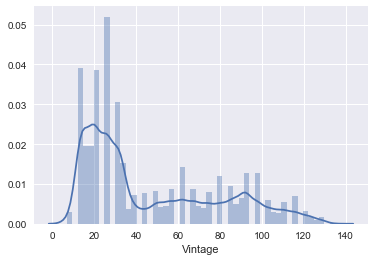

In [43]:
sns.distplot(train['Vintage'])

- As it is not normally distributed,Let's convert it to normal distribution by using box-cox transformation.

<h1>Box-Cox Transformation </h1>

In [45]:
fitted_data, fitted_lambda = boxcox(np.abs(train['Vintage']))
train['Vintage_box_cox'] = fitted_data
fitted_data, fitted_lambda = boxcox(np.abs(test['Vintage']))
test['Vintage_box_cox'] = fitted_data

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


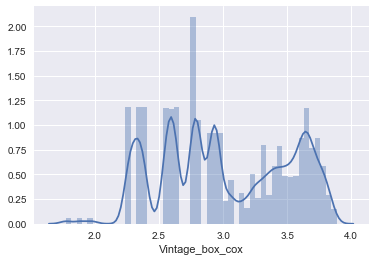

In [47]:
sns.distplot(train['Vintage_box_cox'])

- Multiple spikes but better than the previous one.

<h1>Statistical Feature on the Vintage column (Train Data) </h1>

<h1>Mean Feature </h1>

In [51]:
train['Gender_Vintage_mean']=train.groupby('Gender').Vintage.transform("mean")
train['Occupation_Vintage_mean']=train.groupby('Occupation').Vintage.transform("mean")
train['Region_Code_Vintage_mean']=train.groupby('Region_Code').Vintage.transform("mean")
train['Channel_Code_Vintage_mean']=train.groupby('Channel_Code').Vintage.transform("mean")
train['Credit_product_Vintage_mean']=train.groupby('Credit_Product').Vintage.transform("mean")
train['Is_Active_Vintage_mean']=train.groupby('Is_Active').Vintage.transform("mean")

<h1>Skewness Feature </h1>

In [52]:
train['Gender_Vintage_skew']=train.groupby('Gender').Vintage.transform(lambda x:skew(x))
train['Occupation_Vintage_skew']=train.groupby('Occupation').Vintage.transform(lambda x:skew(x))
train['Region_Code_Vintage_skew']=train.groupby('Region_Code').Vintage.transform(lambda x:skew(x))
train['Channel_Code_Vintage_skew']=train.groupby('Channel_Code').Vintage.transform(lambda x:skew(x))
train['Credit_product_Vintage_skew']=train.groupby('Credit_Product').Vintage.transform(lambda x: skew(x))
train['Is_Active_Vintage_skew']=train.groupby('Is_Active').Vintage.transform(lambda x: skew(x))


<h1>Kurtosis Feature </h1>

In [53]:
train['Gender_Vintage_kur']=train.groupby('Gender').Vintage.transform(lambda x:kurtosis(x))
train['Occupation_Vintage_kur']=train.groupby('Occupation').Vintage.transform(lambda x:kurtosis(x))
train['Region_Code_Vintage_kur']=train.groupby('Region_Code').Vintage.transform(lambda x:kurtosis(x))
train['Channel_Code_Vintage_kur']=train.groupby('Channel_Code').Vintage.transform(lambda x:kurtosis(x))
train['Credit_product_Vintage_kur']=train.groupby('Credit_Product').Vintage.transform(lambda x: kurtosis(x))
train['Is_Active_Vintage_kur']=train.groupby('Is_Active').Vintage.transform(lambda x: kurtosis(x))


<h1>Kstat Feature </h1>

In [54]:
train['Gender_Vintage_kstat']=train.groupby('Gender').Vintage.transform(lambda x:kstat(x))
train['Occupation_Vintage_kstat']=train.groupby('Occupation').Vintage.transform(lambda x:kstat(x))
train['Region_Code_Vintage_kstat']=train.groupby('Region_Code').Vintage.transform(lambda x:kstat(x))
train['Channel_Code_Vintage_kstat']=train.groupby('Channel_Code').Vintage.transform(lambda x:kstat(x))
train['Credit_product_Vintage_kstat']=train.groupby('Credit_Product').Vintage.transform(lambda x: kstat(x))
train['Is_Active_Vintage_kstat']=train.groupby('Is_Active').Vintage.transform(lambda x: kstat(x))


<h1>All the features for Test data Vintage Column </h1>

In [55]:
test['Gender_Vintage_mean']=test.groupby('Gender').Vintage.transform("mean")
test['Occupation_Vintage_mean']=test.groupby('Occupation').Vintage.transform("mean")
test['Region_Code_Vintage_mean']=test.groupby('Region_Code').Vintage.transform("mean")
test['Channel_Code_Vintage_mean']=test.groupby('Channel_Code').Vintage.transform("mean")
test['Credit_product_Vintage_mean']=test.groupby('Credit_Product').Vintage.transform("mean")
test['Is_Active_Vintage_mean']=test.groupby('Is_Active').Vintage.transform("mean")

In [56]:
test['Gender_Vintage_skew']=test.groupby('Gender').Vintage.transform(lambda x:skew(x))
test['Occupation_Vintage_skew']=test.groupby('Occupation').Vintage.transform(lambda x:skew(x))
test['Region_Code_Vintage_skew']=test.groupby('Region_Code').Vintage.transform(lambda x:skew(x))
test['Channel_Code_Vintage_skew']=test.groupby('Channel_Code').Vintage.transform(lambda x:skew(x))
test['Credit_product_Vintage_skew']=test.groupby('Credit_Product').Vintage.transform(lambda x: skew(x))
test['Is_Active_Vintage_skew']=test.groupby('Is_Active').Vintage.transform(lambda x: skew(x))


In [57]:
test['Gender_Vintage_kur']=test.groupby('Gender').Vintage.transform(lambda x:kurtosis(x))
test['Occupation_Vintage_kur']=test.groupby('Occupation').Vintage.transform(lambda x:kurtosis(x))
test['Region_Code_Vintage_kur']=test.groupby('Region_Code').Vintage.transform(lambda x:kurtosis(x))
test['Channel_Code_Vintage_kur']=test.groupby('Channel_Code').Vintage.transform(lambda x:kurtosis(x))
test['Credit_product_Vintage_kur']=test.groupby('Credit_Product').Vintage.transform(lambda x: kurtosis(x))
test['Is_Active_Vintage_kur']=test.groupby('Is_Active').Vintage.transform(lambda x: kurtosis(x))


In [58]:
test['Gender_Vintage_kstat']=test.groupby('Gender').Vintage.transform(lambda x:kstat(x))
test['Occupation_Vintage_kstat']=test.groupby('Occupation').Vintage.transform(lambda x:kstat(x))
test['Region_Code_Vintage_kstat']=test.groupby('Region_Code').Vintage.transform(lambda x:kstat(x))
test['Channel_Code_Vintage_kstat']=test.groupby('Channel_Code').Vintage.transform(lambda x:kstat(x))
test['Credit_product_Vintage_kstat']=test.groupby('Credit_Product').Vintage.transform(lambda x: kstat(x))
test['Is_Active_Vintage_kstat']=test.groupby('Is_Active').Vintage.transform(lambda x: kstat(x))


In [59]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Region_Code_Vintage_kur,Channel_Code_Vintage_kur,Credit_product_Vintage_kur,Is_Active_Vintage_kur,Gender_Vintage_kstat,Occupation_Vintage_kstat,Region_Code_Vintage_kstat,Channel_Code_Vintage_kstat,Credit_product_Vintage_kstat,Is_Active_Vintage_kstat
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,-1.269,-1.021,0.405,0.082,898.235,1178.874,1165.553,1078.248,833.371,873.650
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,-0.194,9.899,0.405,0.082,898.235,287.957,898.306,158.117,833.371,873.650
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,-1.269,-1.021,0.405,-1.248,898.235,1062.060,1165.553,1078.248,833.371,1201.152
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,4.178,9.899,0.405,0.082,1129.062,287.957,516.124,158.117,833.371,873.650
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,-0.033,9.899,0.405,0.082,898.235,287.957,799.172,158.117,833.371,873.650


In [60]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Region_Code_Vintage_kur,Channel_Code_Vintage_kur,Credit_product_Vintage_kur,Is_Active_Vintage_kur,Gender_Vintage_kstat,Occupation_Vintage_kstat,Region_Code_Vintage_kstat,Channel_Code_Vintage_kstat,Credit_product_Vintage_kstat,Is_Active_Vintage_kstat
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,-0.672,9.701,-1.304,0.131,1126.795,1166.529,1068.097,160.583,1203.813,858.282
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,-1.255,-1.253,-1.304,0.131,1126.795,1166.529,1162.719,797.669,1203.813,858.282
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,4.222,9.701,0.407,0.131,1126.795,283.162,535.885,160.583,826.107,858.282
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,-0.394,9.701,0.407,0.131,1126.795,1166.529,905.401,160.583,826.107,858.282
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,4.222,9.701,0.407,0.131,889.336,1166.529,535.885,160.583,826.107,858.282


In [61]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat',
       'Vintage_box_cox', 'Gen

In [62]:
test.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat',
       'Vintage_box_cox', 'Gender_Vintage

In [63]:
train.shape, test.shape

((245723, 60), (105312, 59))

<h1>Polynomial Feature of Degree 3 </h1>

- We will create a temporal dataframe considering all the numerical column.
- We will just do an experimentation on Age,Vintage,Avg_Balance.

In [48]:
temp_train=pd.DataFrame(columns=['Age','Vintage','Avg_Balance'])

In [49]:
temp_train['Age']=train['Age']
temp_train['Vintage']=train['Vintage']
temp_train['Avg_Balance']=train['Avg_Account_Balance']

In [50]:
temp_train.head()

,Age,Vintage,Avg_Balance
0,73,43,1045696
1,30,32,581988
2,56,26,1484315
3,34,19,470454
4,30,33,886787


In [51]:
pf=preprocessing.PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
pf.fit(temp_train)
poly_feats=pf.transform(temp_train)
num_feats=poly_feats.shape[1]
temp_train_transformed=pd.DataFrame(poly_feats,columns=[f"f_{i}" for i in range(1,num_feats+1)])

In [52]:
temp_train_transformed.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,73.000,43.000,1045696.000,5329.000,3139.000,76335808.000,1849.000,44964928.000,1093480124416.000
1,30.000,32.000,581988.000,900.000,960.000,17459640.000,1024.000,18623616.000,338710032144.000
2,56.000,26.000,1484315.000,3136.000,1456.000,83121640.000,676.000,38592190.000,2203191019225.000
3,34.000,19.000,470454.000,1156.000,646.000,15995436.000,361.000,8938626.000,221326966116.000
4,30.000,33.000,886787.000,900.000,990.000,26603610.000,1089.000,29263971.000,786391183369.000


<h1>Same to be Performed on test </h1>

In [53]:
temp_test=pd.DataFrame(columns=['Age','Vintage','Avg_Balance'])

In [54]:
temp_test['Age']=test['Age']
temp_test['Vintage']=test['Vintage']
temp_test['Avg_Balance']=test['Avg_Account_Balance']

In [55]:
temp_test.head()

,Age,Vintage,Avg_Balance
0,29,25,742366
1,43,49,925537
2,31,14,215949
3,29,33,868070
4,29,19,657087


In [56]:
poly_feats=pf.transform(temp_test)
num_feats=poly_feats.shape[1]
temp_test_transformed=pd.DataFrame(poly_feats,columns=[f"f_{i}" for i in range(1,num_feats+1)])

In [57]:
temp_test_transformed.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,29.000,25.000,742366.000,841.000,725.000,21528614.000,625.000,18559150.000,551107277956.000
1,43.000,49.000,925537.000,1849.000,2107.000,39798091.000,2401.000,45351313.000,856618738369.000
2,31.000,14.000,215949.000,961.000,434.000,6694419.000,196.000,3023286.000,46633970601.000
3,29.000,33.000,868070.000,841.000,957.000,25174030.000,1089.000,28646310.000,753545524900.000
4,29.000,19.000,657087.000,841.000,551.000,19055523.000,361.000,12484653.000,431763325569.000


<h1>Merging all feature(Train Data) </h1>

In [58]:
train['f_1']=temp_train_transformed['f_1']
train['f_2']=temp_train_transformed['f_2']
train['f_3']=temp_train_transformed['f_3']
train['f_4']=temp_train_transformed['f_4']
train['f_5']=temp_train_transformed['f_5']
train['f_6']=temp_train_transformed['f_6']
train['f_7']=temp_train_transformed['f_7']
train['f_8']=temp_train_transformed['f_8']
train['f_9']=temp_train_transformed['f_9']

In [59]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Vintage_box_cox,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,3.140,73.000,43.000,1045696.000,5329.000,3139.000,76335808.000,1849.000,44964928.000,1093480124416.000
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,2.934,30.000,32.000,581988.000,900.000,960.000,17459640.000,1024.000,18623616.000,338710032144.000
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,2.785,56.000,26.000,1484315.000,3136.000,1456.000,83121640.000,676.000,38592190.000,2203191019225.000
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,2.554,34.000,19.000,470454.000,1156.000,646.000,15995436.000,361.000,8938626.000,221326966116.000
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,2.956,30.000,33.000,886787.000,900.000,990.000,26603610.000,1089.000,29263971.000,786391183369.000


In [60]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat',
       'Vintage_box_cox', 'f_1

<h1>Merging All Feature for Test_data </h1>

In [61]:
test['f_1']=temp_test_transformed['f_1']
test['f_2']=temp_test_transformed['f_2']
test['f_3']=temp_test_transformed['f_3']
test['f_4']=temp_test_transformed['f_4']
test['f_5']=temp_test_transformed['f_5']
test['f_6']=temp_test_transformed['f_6']
test['f_7']=temp_test_transformed['f_7']
test['f_8']=temp_test_transformed['f_8']
test['f_9']=temp_test_transformed['f_9']

In [62]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Vintage_box_cox,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,2.763,29.000,25.000,742366.000,841.000,725.000,21528614.000,625.000,18559150.000,551107277956.000
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,3.239,43.000,49.000,925537.000,1849.000,2107.000,39798091.000,2401.000,45351313.000,856618738369.000
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,2.327,31.000,14.000,215949.000,961.000,434.000,6694419.000,196.000,3023286.000,46633970601.000
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,2.963,29.000,33.000,868070.000,841.000,957.000,25174030.000,1089.000,28646310.000,753545524900.000
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,2.560,29.000,19.000,657087.000,841.000,551.000,19055523.000,361.000,12484653.000,431763325569.000


In [63]:
train.shape,test.shape

((245723, 45), (105312, 44))

<h1>Binning of Age,Avg_Account_Balance,Vintage(Train Data)</h1>

<h1>AGE </h1>

In [64]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Vintage_box_cox,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,3.140,73.000,43.000,1045696.000,5329.000,3139.000,76335808.000,1849.000,44964928.000,1093480124416.000
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,2.934,30.000,32.000,581988.000,900.000,960.000,17459640.000,1024.000,18623616.000,338710032144.000
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,2.785,56.000,26.000,1484315.000,3136.000,1456.000,83121640.000,676.000,38592190.000,2203191019225.000
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,2.554,34.000,19.000,470454.000,1156.000,646.000,15995436.000,361.000,8938626.000,221326966116.000
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,2.956,30.000,33.000,886787.000,900.000,990.000,26603610.000,1089.000,29263971.000,786391183369.000


The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


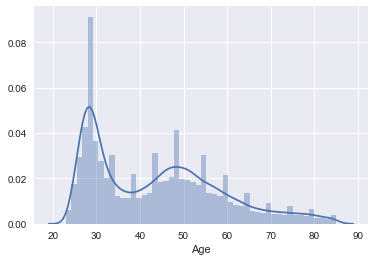

In [65]:
sns.distplot(train['Age'])

- As we can see,there is a clear-cut pattern in this column. Binning will help us to get more intuitions.

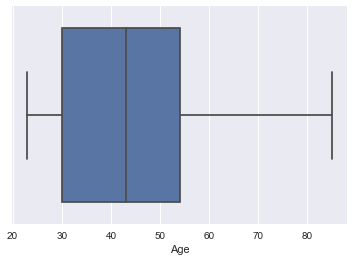

In [66]:
sns.boxplot(train['Age'])

In [67]:
train['Age'].describe()

count   245723.000
mean        43.856
std         14.829
min         23.000
25%         30.000
50%         43.000
75%         54.000
max         85.000
Name: Age, dtype: float64

In [70]:
age_bins = [25, 35, 45, 75]
cats=pd.cut(train['Age'], age_bins, right = False)
train["Age_Cat"] = cats
group_names = ["young_adult", "adult", "elderly"]
train['Age_Cat']=pd.cut(train['Age'], age_bins, right = False, labels = group_names)

In [71]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,Age_Cat
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,73.000,43.000,1045696.000,5329.000,3139.000,76335808.000,1849.000,44964928.000,1093480124416.000,elderly
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,30.000,32.000,581988.000,900.000,960.000,17459640.000,1024.000,18623616.000,338710032144.000,young_adult
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,56.000,26.000,1484315.000,3136.000,1456.000,83121640.000,676.000,38592190.000,2203191019225.000,elderly
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,34.000,19.000,470454.000,1156.000,646.000,15995436.000,361.000,8938626.000,221326966116.000,young_adult
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,30.000,33.000,886787.000,900.000,990.000,26603610.000,1089.000,29263971.000,786391183369.000,young_adult


# Similar Stats Feature of Age

- Here We will experiement and invent new columns according to the binning we have done on the AGE.
- We will experiement with basic stats features only.
- We will bin the age column also.

In [73]:
train['Age_Avg_Income_mean']=train.groupby('Age_Cat').Avg_Account_Balance.transform("mean")
train['Age_Avg_Income_skew']=train.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:skew(x))
train['Age_Avg_Income_kur']=train.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:kurtosis(x))
train['Age_Avg_Income_kstat']=train.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:kstat(x))

In [86]:
train['Age_Vintage_mean']=train.groupby('Age_Cat').Vintage.transform("mean")
train['Age_Vintage_skew']=train.groupby('Age_Cat').Vintage.transform(lambda x:skew(x))
train['Age_Vintage_kur']=train.groupby('Age_Cat').Vintage.transform(lambda x:kurtosis(x))
train['Age_Vintage_kstat']=train.groupby('Age_Cat').Vintage.transform(lambda x:kstat(x))

In [87]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,f_9,Age_Cat,Age_Avg_Income_mean,Age_Avg_Income_skew,Age_Avg_Income_kur,Age_Avg_Income_kstat,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,1093480124416.000,elderly,1318773.372,2.549,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,338710032144.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,2203191019225.000,elderly,1318773.372,2.549,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,221326966116.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,786391183369.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565


In [88]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,f_9,Age_Cat,Age_Avg_Income_mean,Age_Avg_Income_skew,Age_Avg_Income_kur,Age_Avg_Income_kstat,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,1093480124416.000,elderly,1318773.372,2.549,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,338710032144.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,2203191019225.000,elderly,1318773.372,2.549,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,221326966116.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,786391183369.000,adult,1094472.771,3.089,15.601,677106903411.286,47.127,0.754,-0.673,909.565


In [89]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Is_Active_Vintage_kstat,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,858.282,29.000,25.000,742366.000,841.000,725.000,21528614.000,625.000,18559150.000,551107277956.000
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,858.282,43.000,49.000,925537.000,1849.000,2107.000,39798091.000,2401.000,45351313.000,856618738369.000
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,858.282,31.000,14.000,215949.000,961.000,434.000,6694419.000,196.000,3023286.000,46633970601.000
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,858.282,29.000,33.000,868070.000,841.000,957.000,25174030.000,1089.000,28646310.000,753545524900.000
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,858.282,29.000,19.000,657087.000,841.000,551.000,19055523.000,361.000,12484653.000,431763325569.000


In [90]:
age_bins = [18, 30, 55, 100]
cats=pd.cut(test['Age'], age_bins, right = False)
test["Age_Cat"] = cats
group_names = ["young_adult", "adult", "elderly"]
test['Age_Cat']=pd.cut(test['Age'], age_bins, right = False, labels = group_names)

In [91]:
test['Age_Avg_Income_mean']=test.groupby('Age_Cat').Avg_Account_Balance.transform("mean")
test['Age_Avg_Income_skew']=test.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:skew(x))
test['Age_Avg_Income_kur']=test.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:kurtosis(x))
test['Age_Avg_Income_kstat']=test.groupby('Age_Cat').Avg_Account_Balance.transform(lambda x:kstat(x))

In [92]:
test['Age_Vintage_mean']=test.groupby('Age_Cat').Vintage.transform("mean")
test['Age_Vintage_skew']=test.groupby('Age_Cat').Vintage.transform(lambda x:skew(x))
test['Age_Vintage_kur']=test.groupby('Age_Cat').Vintage.transform(lambda x:kurtosis(x))
test['Age_Vintage_kstat']=test.groupby('Age_Cat').Vintage.transform(lambda x:kstat(x))

In [93]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,f_9,Age_Cat,Age_Avg_Income_mean,Age_Avg_Income_skew,Age_Avg_Income_kur,Age_Avg_Income_kstat,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,551107277956.000,young_adult,1031417.692,3.336,17.534,679621873886.961,20.797,0.467,-0.745,40.556
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,856618738369.000,adult,1098968.082,3.114,15.790,691012379362.744,47.384,0.731,-0.718,916.676
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,46633970601.000,adult,1098968.082,3.114,15.790,691012379362.744,47.384,0.731,-0.718,916.676
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,753545524900.000,young_adult,1031417.692,3.336,17.534,679621873886.961,20.797,0.467,-0.745,40.556
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,431763325569.000,young_adult,1031417.692,3.336,17.534,679621873886.961,20.797,0.467,-0.745,40.556


In [94]:
kbin = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
kbin.fit(train['Age'].values.reshape(-1,1))
train['Age_quantiles'] = kbin.transform(train['Age'].values.reshape(-1,1)).astype(int)
test['Age_quantiles'] = kbin.transform(test['Age'].values.reshape(-1,1)).astype(int)

In [95]:
train.shape,test.shape

((245723, 79), (105312, 78))

<h1>Binning of Avg_Account_Balance </h1>

In [96]:
train['Avg_Account_Balance_b10']=pd.cut(train['Avg_Account_Balance'],bins=10,labels=False)
train['Avg_Account_Balance_b1000']=pd.cut(train['Avg_Account_Balance'],bins=1000,labels=False)
train['Avg_Account_Balance_b10000']=pd.cut(train['Avg_Account_Balance'],bins=10000,labels=False)

In [97]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Age_Avg_Income_kur,Age_Avg_Income_kstat,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat,Age_quantiles,Avg_Account_Balance_b10,Avg_Account_Balance_b1000,Avg_Account_Balance_b10000
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096,7,1,104,1048
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,15.601,677106903411.286,47.127,0.754,-0.673,909.565,2,0,57,574
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,10.398,894234540942.180,72.535,-0.255,-0.948,1023.096,6,1,149,1497
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,15.601,677106903411.286,47.127,0.754,-0.673,909.565,2,0,46,460
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,15.601,677106903411.286,47.127,0.754,-0.673,909.565,2,0,88,886


In [98]:
test['Avg_Account_Balance_b10']=pd.cut(test['Avg_Account_Balance'],bins=10,labels=False)
test['Avg_Account_Balance_b1000']=pd.cut(test['Avg_Account_Balance'],bins=1000,labels=False)
test['Avg_Account_Balance_b10000']=pd.cut(test['Avg_Account_Balance'],bins=10000,labels=False)

<h1>k-Bin for Avg_Account Balance </h1>

In [99]:
kbin = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
kbin.fit(train['Avg_Account_Balance'].values.reshape(-1,1))
train['Avg_Account_Balance_quantiles'] = kbin.transform(train['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)
test['Avg_Account_Balance_quantiles'] = kbin.transform(test['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)

In [100]:
train.shape,test.shape

((245723, 83), (105312, 82))

<h1>Binning of Vintage </h1>

In [101]:
train['Vintage_b10']=pd.cut(train['Vintage'],bins=10,labels=False)

In [102]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat,Age_quantiles,Avg_Account_Balance_b10,Avg_Account_Balance_b1000,Avg_Account_Balance_b10000,Avg_Account_Balance_quantiles,Vintage_b10
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,...,72.535,-0.255,-0.948,1023.096,7,1,104,1048,4,2
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,...,47.127,0.754,-0.673,909.565,2,0,57,574,1,1
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,...,72.535,-0.255,-0.948,1023.096,6,1,149,1497,6,1
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,...,47.127,0.754,-0.673,909.565,2,0,46,460,1,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,...,47.127,0.754,-0.673,909.565,2,0,88,886,3,2


In [103]:
test['Vintage_b10']=pd.cut(test['Vintage'],bins=10,labels=False)

In [104]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Age_Vintage_mean,Age_Vintage_skew,Age_Vintage_kur,Age_Vintage_kstat,Age_quantiles,Avg_Account_Balance_b10,Avg_Account_Balance_b1000,Avg_Account_Balance_b10000,Avg_Account_Balance_quantiles,Vintage_b10
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,...,20.797,0.467,-0.745,40.556,1,0,72,728,3,1
1,CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No,...,47.384,0.731,-0.718,916.676,4,0,91,913,4,3
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,...,47.384,0.731,-0.718,916.676,2,0,19,195,0,0
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,...,20.797,0.467,-0.745,40.556,1,0,85,855,3,2
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,...,20.797,0.467,-0.745,40.556,1,0,64,641,2,0


<h1>k-Bin of Vintage(Train and Test) </h1>

In [105]:
kbin = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
kbin.fit(train['Vintage'].values.reshape(-1,1))
train['Vintage_quantiles'] = kbin.transform(train['Vintage'].values.reshape(-1,1)).astype(int)
test['Vintage_quantiles'] = kbin.transform(test['Vintage'].values.reshape(-1,1)).astype(int)

In [106]:
train.shape,test.shape

((245723, 85), (105312, 84))

<h1>General Transformation of Existing Feature(Avg_Account,Vintage,Age,Gender,Region_code,Occupation,Channel_Code,Credit_Product,Is_Active)</h1>

<h1>Log transformation on Avg_Account and Vintage</h1>

In [107]:
train['Avg_Account_Balance_log'] = np.log(train['Avg_Account_Balance'])
test['Avg_Account_Balance_log'] = np.log(test['Avg_Account_Balance'])


In [108]:
train['Vintage_log'] = np.log(train['Vintage'])
test['Vintage_log'] = np.log(test['Vintage'])

<h1>Label Encoding on Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active </h1>

In [109]:
le = LabelEncoder()
le.fit(train['Gender'])
train['Gender'] = le.transform(train['Gender'])
test['Gender'] = le.transform(test['Gender'])

In [110]:
le_oc = LabelEncoder()
le_oc.fit(train['Occupation'])
train['Occupation'] = le_oc.transform(train['Occupation'])
test['Occupation'] = le_oc.transform(test['Occupation'])

In [111]:
le_cc = LabelEncoder()
le_cc.fit(train['Channel_Code'])
train['Channel_Code'] = le_cc.transform(train['Channel_Code'])
test['Channel_Code'] = le_cc.transform(test['Channel_Code'])


In [112]:
le_cp = LabelEncoder()
le_cp.fit(train['Credit_Product'])
train['Credit_Product'] = le_cp.transform(train['Credit_Product'])
test['Credit_Product'] = le_cp.transform(test['Credit_Product'])

In [113]:
le_ia = LabelEncoder()
le_ia.fit(train['Is_Active'])
train['Is_Active'] = le_ia.transform(train['Is_Active'])
test['Is_Active'] = le_ia.transform(test['Is_Active'])


<h1>Frequency Encoding of Region_Code </h1>

In [114]:
region_grp=(train.groupby('Region_Code').size())/len(train)
train['Region_freq']=train['Region_Code'].apply(lambda x:region_grp[x])

In [115]:
region_grp=(test.groupby('Region_Code').size())/len(test)
test['Region_freq']=test['Region_Code'].apply(lambda x:region_grp[x])

In [116]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Age_quantiles,Avg_Account_Balance_b10,Avg_Account_Balance_b1000,Avg_Account_Balance_b10000,Avg_Account_Balance_quantiles,Vintage_b10,Vintage_quantiles,Avg_Account_Balance_log,Vintage_log,Region_freq
0,NNVBBKZB,0,73,RG268,1,2,43,0,1045696,0,...,7,1,104,1048,4,2,4,13.860,3.761,0.146
1,IDD62UNG,0,30,RG277,2,0,32,0,581988,0,...,2,0,57,574,1,1,4,13.274,3.466,0.052
2,HD3DSEMC,0,56,RG268,3,2,26,0,1484315,1,...,6,1,149,1497,6,1,3,14.210,3.258,0.146
3,BF3NC7KV,1,34,RG270,2,0,19,0,470454,0,...,2,0,46,460,1,0,1,13.061,2.944,0.031
4,TEASRWXV,0,30,RG282,2,0,33,0,886787,0,...,2,0,88,886,3,2,4,13.695,3.497,0.024


In [117]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,...,Age_quantiles,Avg_Account_Balance_b10,Avg_Account_Balance_b1000,Avg_Account_Balance_b10000,Avg_Account_Balance_quantiles,Vintage_b10,Vintage_quantiles,Avg_Account_Balance_log,Vintage_log,Region_freq
0,VBENBARO,1,29,RG254,1,0,25,1,742366,0,...,1,0,72,728,3,1,2,13.518,3.219,0.111
1,CCMEWNKY,1,43,RG268,1,1,49,1,925537,0,...,4,0,91,913,4,3,4,13.738,3.892,0.144
2,VK3KGA9M,1,31,RG270,2,0,14,0,215949,0,...,2,0,19,195,0,0,0,12.283,2.639,0.033
3,TT8RPZVC,1,29,RG272,1,0,33,0,868070,0,...,1,0,85,855,3,2,4,13.674,3.497,0.022
4,SHQZEYTZ,0,29,RG270,1,0,19,0,657087,0,...,1,0,64,641,2,0,1,13.396,2.944,0.033


In [118]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat',
       'Vintage_box_cox', 'Gen

In [119]:
test.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Gender_Avg_Income_mean', 'Occupation_Avg_Income_mean',
       'Region_Code_Avg_Income_mean', 'Channel_Code_Avg_Income_mean',
       'Credit_product_Avg_Income_mean', 'Is_Active_Avg_Income_mean',
       'Gender_Avg_Income_skew', 'Occupation_Avg_Income_skew',
       'Region_Code_Avg_Income_skew', 'Channel_Code_Avg_Income_skew',
       'Credit_product_Avg_Income_skew', 'Is_Active_Avg_Income_skew',
       'Gender_Avg_Income_kur', 'Occupation_Avg_Income_kur',
       'Region_Code_Avg_Income_kur', 'Channel_Code_Avg_Income_kur',
       'Credit_product_Avg_Income_kur', 'Is_Active_Avg_Income_kur',
       'Gender_Avg_Income_kstat', 'Occupation_Avg_Income_kstat',
       'Region_Code_Avg_Income_kstat', 'Channel_Code_Avg_Income_kstat',
       'Credit_product_Avg_Income_kstat', 'Is_Active_Avg_Income_kstat',
       'Vintage_box_cox', 'Gender_Vintage

<h1>Dropping Unnecessary Columns (Train Data) </h1>

In [120]:
train.drop(['ID','Age_Cat', 'Region_Code','Vintage','Avg_Account_Balance','Vintage','Age'],axis=1,inplace=True)

<h1>Dropping Unnecessary Column(Test Data) </h1>

In [121]:
test.drop(['ID','Age_Cat', 'Region_Code','Vintage','Avg_Account_Balance','Vintage','Age'],axis=1,inplace=True)

In [122]:
train.to_csv('all_feature_df_train.csv',index=False)
test.to_csv('all_feature_df_test.csv',index=False)

<H1>Splitting the data </h1>

In [125]:
y=train['Is_Lead'].values
train.drop(['Is_Lead'],axis=1,inplace=True)

In [126]:
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(train,y,test_size=0.2,random_state=22,stratify=y)

<h1>Normalizing the data (Train,Test,Valid)</h1>

In [124]:
from sklearn.preprocessing import Normalizer
normal=Normalizer()
X_train=normal.fit_transform(X_train)
X_valid=normal.transform(X_valid)

In [125]:
from sklearn.preprocessing import Normalizer
normal=Normalizer()
train_transformed=normal.fit_transform(train)
test_transformed=normal.transform(test)

In [126]:
train_transformed

array([[0.00000000e+00, 4.13293135e-13, 8.26586269e-13, ...,
        5.72832272e-12, 1.55447819e-12, 6.04374121e-14],
       [0.00000000e+00, 1.13113798e-12, 0.00000000e+00, ...,
        7.50747879e-12, 1.96011276e-12, 2.95209967e-14],
       [0.00000000e+00, 9.70300284e-13, 6.46866856e-13, ...,
        4.59613906e-12, 1.05377733e-12, 4.72968886e-14],
       ...,
       [0.00000000e+00, 1.17082310e-12, 0.00000000e+00, ...,
        7.85389079e-12, 1.50155098e-12, 1.21335855e-14],
       [0.00000000e+00, 1.19234978e-12, 0.00000000e+00, ...,
        7.70127160e-12, 2.04725695e-12, 1.09106534e-14],
       [4.65252244e-13, 9.30504487e-13, 0.00000000e+00, ...,
        6.48426112e-12, 1.41647089e-12, 1.48878143e-14]])

In [127]:
test_transformed

array([[4.68313188e-13, 4.68313188e-13, 0.00000000e+00, ...,
        6.33046926e-12, 1.50744200e-12, 5.21934052e-14],
       [4.39543365e-13, 4.39543365e-13, 4.39543365e-13, ...,
        6.03850362e-12, 1.71062379e-12, 6.31275960e-14],
       [5.71730863e-13, 1.14346173e-12, 0.00000000e+00, ...,
        7.02245444e-12, 1.50883052e-12, 1.86754992e-14],
       ...,
       [2.85949104e-13, 5.71898208e-13, 8.57847313e-13, ...,
        4.10289176e-12, 7.74364529e-13, 3.18689668e-14],
       [4.41720114e-13, 4.41720114e-13, 8.83440227e-13, ...,
        5.96789699e-12, 2.00214036e-12, 4.92296127e-14],
       [5.61093589e-13, 1.12218718e-12, 0.00000000e+00, ...,
        7.45722941e-12, 1.70826202e-12, 6.36153283e-15]])

<h1>Minmax Scalling </h1>

In [127]:
transformer = MaxAbsScaler().fit(X_train)
X_train_minmax= transformer.transform(X_train)
X_valid_minmax = transformer.transform(X_valid)

In [128]:
min_max = MaxAbsScaler().fit(train)
train_minmax=min_max.transform(train)
test_minmax=min_max.transform(test)

In [129]:
train_minmax

array([[0.        , 0.33333333, 0.66666667, ..., 0.86103358, 0.76676645,
        1.        ],
       [0.        , 0.66666667, 0.        , ..., 0.82463038, 0.70653247,
        0.35694209],
       [0.        , 1.        , 0.66666667, ..., 0.88279337, 0.66420266,
        1.        ],
       ...,
       [0.        , 0.66666667, 0.        , ..., 0.83344007, 0.52289616,
        0.14173601],
       [0.        , 0.66666667, 0.        , ..., 0.80248988, 0.70006011,
        0.12514958],
       [1.        , 0.66666667, 0.        , ..., 0.86581045, 0.62066298,
        0.21882392]])

In [130]:
test_minmax

array([[1.        , 0.33333333, 0.        , ..., 0.8397506 , 0.65620704,
        0.76213442],
       [1.        , 0.33333333, 0.33333333, ..., 0.85345064, 0.79339496,
        0.98213198],
       [1.        , 0.66666667, 0.        , ..., 0.76304139, 0.53800398,
        0.22337415],
       ...,
       [1.        , 0.66666667, 1.        , ..., 0.89135791, 0.55206901,
        0.76213442],
       [1.        , 0.33333333, 0.66666667, ..., 0.83931493, 0.9240256 ,
        0.76213442],
       [1.        , 0.66666667, 0.        , ..., 0.82564433, 0.62066298,
        0.07753161]])

<h1>Model Training </h1>

<h1>Stacking Logistic Regression,XGboost, LGBM, Catboost </h1>

<h1>Logistic Regression (Hyper-Parameter TUning) </h1>

In [151]:
lr=LogisticRegression()
param_dict={'penalty':['l1', 'l2'],
            'C':[0.001,0.01,0.1,1,10]}

grid_model = GridSearchCV(lr, param_dict, cv = 3, verbose = 1, 
                      n_jobs = -1,scoring='roc_auc')
grid_model.fit(X_train_minmax, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.4s finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [152]:
grid_model.best_params_

{'C': 10, 'penalty': 'l2'}

In [128]:
lr=LogisticRegression(penalty='l2',class_weight='balanced',C=10,max_iter=500)
lr.fit(X_train_minmax,y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=10, class_weight='balanced', max_iter=500)

In [129]:
roc_auc_score(y_train,lr.predict_proba(X_train_minmax)[:,1])

0.7489578528906105

In [130]:
roc_auc_score(y_valid,lr.predict_proba(X_valid_minmax)[:,1])

0.7464502735410803

In [132]:
lr=LogisticRegression(penalty='l2',class_weight='balanced',C=10)
lr.fit(train_minmax,y)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=10, class_weight='balanced')

In [133]:
predict_proba_lr=lr.predict_proba(test_minmax)[:,1]

In [134]:
predict_proba_lr

array([0.15073055, 0.60113684, 0.33839066, ..., 0.59068312, 0.61891885,
       0.21440106])

<h1>Xgboost </h1>

In [131]:
xgboost=XGBClassifier(n_estimators=20000,
                      max_depth=6,
                      learning_rate=0.0201,
                      reg_lambda=29.326,
                      subsample=0.818,
                      colsample_bytree=0.235,
                     colsample_bynode=0.820,
                     colsample_bylevel=0.453)
xgboost.fit(train_minmax,y)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:31:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.453,
              colsample_bynode=0.82, colsample_bytree=0.235, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0201, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20000, n_jobs=12, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=29.326,
              scale_pos_weight=1, subsample=0.818, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [132]:
prediction=xgboost.predict_proba(test_minmax)[:,1]

In [135]:
roc_auc_score(y_train,xgboost.predict_proba(X_train_minmax)[:,1])

0.8919611738188331

In [136]:
roc_auc_score(y_valid,xgboost.predict_proba(X_valid_minmax)[:,1])

0.7708591835887728

In [135]:
xgboost=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.453,
              colsample_bynode=0.82, colsample_bytree=0.235, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0201, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=20000, n_jobs=12, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=29.326,
              scale_pos_weight=1, subsample=0.818, tree_method='exact',
              validate_parameters=1, verbosity=None)

xgboost.fit(train_minmax,y)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[00:36:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.453,
              colsample_bynode=0.82, colsample_bytree=0.235, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0201, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20000, n_jobs=12, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=29.326,
              scale_pos_weight=1, subsample=0.818, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [142]:
predict_proba_xgboost=xgboost.predict_proba(test_minmax)[:,1]

In [143]:
predict_proba_xgboost

array([0.0362964 , 0.25578323, 0.13817681, ..., 0.42732233, 0.4867575 ,
       0.08724832], dtype=float32)

<h1>LGBM </h1>

In [137]:
lgbm=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.045, max_bin=94,
               max_depth=27, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=10,
               objective=None, random_state=None, reg_alpha=6.853,
               reg_lambda=0.0, silent=True, subsample=0.749,
               subsample_for_bin=200000, subsample_freq=0)

lgbm.fit(train_minmax,y)

LGBMClassifier(learning_rate=0.045, max_bin=94, max_depth=27, n_estimators=2000,
               num_leaves=10, reg_alpha=6.853, subsample=0.749)

In [144]:
predict_proba_lgbm=lgbm.predict_proba(test_minmax)[:,1]

In [153]:
predict_proba_lgbm

array([0.04150599, 0.24925172, 0.07860028, ..., 0.46738615, 0.48456291,
       0.06961233])

In [146]:
catboost=CatBoostClassifier(n_estimators= 5000,
                            learning_rate=0.023,
                            colsample_bylevel=0.655,
                            bagging_temperature=0.921,
                            l2_leaf_reg=10.133)

catboost.fit(train_minmax,y)

0:	learn: 0.6804594	total: 205ms	remaining: 17m 5s
1:	learn: 0.6680382	total: 264ms	remaining: 10m 59s
2:	learn: 0.6558169	total: 323ms	remaining: 8m 57s
3:	learn: 0.6447872	total: 373ms	remaining: 7m 46s
4:	learn: 0.6342793	total: 426ms	remaining: 7m 5s
5:	learn: 0.6243317	total: 519ms	remaining: 7m 11s
6:	learn: 0.6153124	total: 585ms	remaining: 6m 57s
7:	learn: 0.6064734	total: 637ms	remaining: 6m 37s
8:	learn: 0.5979716	total: 693ms	remaining: 6m 24s
9:	learn: 0.5903311	total: 745ms	remaining: 6m 11s
10:	learn: 0.5829058	total: 798ms	remaining: 6m 1s
11:	learn: 0.5758614	total: 851ms	remaining: 5m 53s
12:	learn: 0.5691379	total: 914ms	remaining: 5m 50s
13:	learn: 0.5628931	total: 969ms	remaining: 5m 44s
14:	learn: 0.5572170	total: 1.02s	remaining: 5m 39s
15:	learn: 0.5516963	total: 1.07s	remaining: 5m 33s
16:	learn: 0.5465344	total: 1.12s	remaining: 5m 29s
17:	learn: 0.5415959	total: 1.21s	remaining: 5m 35s
18:	learn: 0.5367842	total: 1.28s	remaining: 5m 36s
19:	learn: 0.5323228	to

158:	learn: 0.4429148	total: 9.19s	remaining: 4m 39s
159:	learn: 0.4428733	total: 9.25s	remaining: 4m 39s
160:	learn: 0.4428248	total: 9.3s	remaining: 4m 39s
161:	learn: 0.4427669	total: 9.36s	remaining: 4m 39s
162:	learn: 0.4427373	total: 9.44s	remaining: 4m 40s
163:	learn: 0.4426787	total: 9.49s	remaining: 4m 39s
164:	learn: 0.4425780	total: 9.54s	remaining: 4m 39s
165:	learn: 0.4425306	total: 9.61s	remaining: 4m 39s
166:	learn: 0.4424885	total: 9.67s	remaining: 4m 39s
167:	learn: 0.4424371	total: 9.72s	remaining: 4m 39s
168:	learn: 0.4423432	total: 9.79s	remaining: 4m 39s
169:	learn: 0.4423030	total: 9.85s	remaining: 4m 39s
170:	learn: 0.4422811	total: 9.96s	remaining: 4m 41s
171:	learn: 0.4422313	total: 10s	remaining: 4m 41s
172:	learn: 0.4422007	total: 10.1s	remaining: 4m 40s
173:	learn: 0.4421687	total: 10.1s	remaining: 4m 40s
174:	learn: 0.4421275	total: 10.2s	remaining: 4m 40s
175:	learn: 0.4421012	total: 10.2s	remaining: 4m 40s
176:	learn: 0.4420632	total: 10.3s	remaining: 4m 

318:	learn: 0.4388201	total: 18.4s	remaining: 4m 30s
319:	learn: 0.4388074	total: 18.5s	remaining: 4m 29s
320:	learn: 0.4387976	total: 18.5s	remaining: 4m 29s
321:	learn: 0.4387858	total: 18.6s	remaining: 4m 29s
322:	learn: 0.4387660	total: 18.6s	remaining: 4m 29s
323:	learn: 0.4387422	total: 18.7s	remaining: 4m 29s
324:	learn: 0.4387275	total: 18.8s	remaining: 4m 30s
325:	learn: 0.4387078	total: 18.8s	remaining: 4m 29s
326:	learn: 0.4386970	total: 18.9s	remaining: 4m 29s
327:	learn: 0.4386897	total: 18.9s	remaining: 4m 29s
328:	learn: 0.4386556	total: 19s	remaining: 4m 29s
329:	learn: 0.4386453	total: 19s	remaining: 4m 29s
330:	learn: 0.4386356	total: 19.1s	remaining: 4m 29s
331:	learn: 0.4386217	total: 19.1s	remaining: 4m 29s
332:	learn: 0.4386129	total: 19.2s	remaining: 4m 28s
333:	learn: 0.4385996	total: 19.2s	remaining: 4m 28s
334:	learn: 0.4385885	total: 19.3s	remaining: 4m 28s
335:	learn: 0.4385760	total: 19.4s	remaining: 4m 28s
336:	learn: 0.4385584	total: 19.4s	remaining: 4m 2

475:	learn: 0.4369954	total: 27.3s	remaining: 4m 19s
476:	learn: 0.4369910	total: 27.4s	remaining: 4m 19s
477:	learn: 0.4369856	total: 27.5s	remaining: 4m 19s
478:	learn: 0.4369819	total: 27.5s	remaining: 4m 19s
479:	learn: 0.4369549	total: 27.6s	remaining: 4m 19s
480:	learn: 0.4369448	total: 27.7s	remaining: 4m 19s
481:	learn: 0.4369372	total: 27.7s	remaining: 4m 19s
482:	learn: 0.4369312	total: 27.8s	remaining: 4m 19s
483:	learn: 0.4369158	total: 27.9s	remaining: 4m 20s
484:	learn: 0.4368937	total: 27.9s	remaining: 4m 20s
485:	learn: 0.4368844	total: 28s	remaining: 4m 19s
486:	learn: 0.4368738	total: 28s	remaining: 4m 19s
487:	learn: 0.4368651	total: 28.1s	remaining: 4m 20s
488:	learn: 0.4368545	total: 28.2s	remaining: 4m 20s
489:	learn: 0.4368480	total: 28.3s	remaining: 4m 20s
490:	learn: 0.4368357	total: 28.3s	remaining: 4m 20s
491:	learn: 0.4368267	total: 28.4s	remaining: 4m 20s
492:	learn: 0.4368227	total: 28.4s	remaining: 4m 20s
493:	learn: 0.4368034	total: 28.5s	remaining: 4m 1

632:	learn: 0.4357586	total: 37.8s	remaining: 4m 21s
633:	learn: 0.4357543	total: 37.9s	remaining: 4m 21s
634:	learn: 0.4357485	total: 38s	remaining: 4m 21s
635:	learn: 0.4357435	total: 38.1s	remaining: 4m 21s
636:	learn: 0.4357372	total: 38.1s	remaining: 4m 21s
637:	learn: 0.4357319	total: 38.2s	remaining: 4m 21s
638:	learn: 0.4357251	total: 38.3s	remaining: 4m 21s
639:	learn: 0.4357192	total: 38.4s	remaining: 4m 21s
640:	learn: 0.4357141	total: 38.4s	remaining: 4m 21s
641:	learn: 0.4357090	total: 38.5s	remaining: 4m 21s
642:	learn: 0.4357051	total: 38.6s	remaining: 4m 21s
643:	learn: 0.4356962	total: 38.7s	remaining: 4m 21s
644:	learn: 0.4356910	total: 38.7s	remaining: 4m 21s
645:	learn: 0.4356805	total: 38.8s	remaining: 4m 21s
646:	learn: 0.4356755	total: 38.8s	remaining: 4m 21s
647:	learn: 0.4356685	total: 38.9s	remaining: 4m 21s
648:	learn: 0.4356642	total: 39s	remaining: 4m 21s
649:	learn: 0.4356581	total: 39s	remaining: 4m 21s
650:	learn: 0.4356445	total: 39.2s	remaining: 4m 21s

790:	learn: 0.4347963	total: 47.7s	remaining: 4m 13s
791:	learn: 0.4347861	total: 47.8s	remaining: 4m 13s
792:	learn: 0.4347796	total: 47.8s	remaining: 4m 13s
793:	learn: 0.4347732	total: 47.9s	remaining: 4m 13s
794:	learn: 0.4347669	total: 47.9s	remaining: 4m 13s
795:	learn: 0.4347629	total: 48s	remaining: 4m 13s
796:	learn: 0.4347496	total: 48.1s	remaining: 4m 13s
797:	learn: 0.4347422	total: 48.1s	remaining: 4m 13s
798:	learn: 0.4347402	total: 48.2s	remaining: 4m 13s
799:	learn: 0.4347364	total: 48.2s	remaining: 4m 13s
800:	learn: 0.4347328	total: 48.3s	remaining: 4m 13s
801:	learn: 0.4347287	total: 48.3s	remaining: 4m 13s
802:	learn: 0.4347225	total: 48.4s	remaining: 4m 12s
803:	learn: 0.4347178	total: 48.5s	remaining: 4m 12s
804:	learn: 0.4347133	total: 48.5s	remaining: 4m 12s
805:	learn: 0.4347059	total: 48.6s	remaining: 4m 12s
806:	learn: 0.4347006	total: 48.6s	remaining: 4m 12s
807:	learn: 0.4346953	total: 48.7s	remaining: 4m 12s
808:	learn: 0.4346911	total: 48.8s	remaining: 4m

949:	learn: 0.4339091	total: 57.6s	remaining: 4m 5s
950:	learn: 0.4339052	total: 57.6s	remaining: 4m 5s
951:	learn: 0.4339007	total: 57.7s	remaining: 4m 5s
952:	learn: 0.4338968	total: 57.8s	remaining: 4m 5s
953:	learn: 0.4338918	total: 57.8s	remaining: 4m 5s
954:	learn: 0.4338873	total: 57.9s	remaining: 4m 5s
955:	learn: 0.4338790	total: 57.9s	remaining: 4m 5s
956:	learn: 0.4338729	total: 58s	remaining: 4m 4s
957:	learn: 0.4338685	total: 58s	remaining: 4m 4s
958:	learn: 0.4338625	total: 58.1s	remaining: 4m 4s
959:	learn: 0.4338576	total: 58.1s	remaining: 4m 4s
960:	learn: 0.4338517	total: 58.2s	remaining: 4m 4s
961:	learn: 0.4338480	total: 58.3s	remaining: 4m 4s
962:	learn: 0.4338444	total: 58.3s	remaining: 4m 4s
963:	learn: 0.4338399	total: 58.4s	remaining: 4m 4s
964:	learn: 0.4338295	total: 58.4s	remaining: 4m 4s
965:	learn: 0.4338248	total: 58.5s	remaining: 4m 4s
966:	learn: 0.4338208	total: 58.5s	remaining: 4m 4s
967:	learn: 0.4338153	total: 58.6s	remaining: 4m 4s
968:	learn: 0.43

1109:	learn: 0.4331053	total: 1m 7s	remaining: 3m 55s
1110:	learn: 0.4331009	total: 1m 7s	remaining: 3m 55s
1111:	learn: 0.4330967	total: 1m 7s	remaining: 3m 55s
1112:	learn: 0.4330902	total: 1m 7s	remaining: 3m 55s
1113:	learn: 0.4330867	total: 1m 7s	remaining: 3m 55s
1114:	learn: 0.4330793	total: 1m 7s	remaining: 3m 55s
1115:	learn: 0.4330744	total: 1m 7s	remaining: 3m 55s
1116:	learn: 0.4330710	total: 1m 7s	remaining: 3m 55s
1117:	learn: 0.4330644	total: 1m 7s	remaining: 3m 55s
1118:	learn: 0.4330591	total: 1m 7s	remaining: 3m 54s
1119:	learn: 0.4330548	total: 1m 7s	remaining: 3m 54s
1120:	learn: 0.4330505	total: 1m 7s	remaining: 3m 54s
1121:	learn: 0.4330474	total: 1m 7s	remaining: 3m 54s
1122:	learn: 0.4330440	total: 1m 8s	remaining: 3m 54s
1123:	learn: 0.4330404	total: 1m 8s	remaining: 3m 54s
1124:	learn: 0.4330373	total: 1m 8s	remaining: 3m 54s
1125:	learn: 0.4330337	total: 1m 8s	remaining: 3m 54s
1126:	learn: 0.4330246	total: 1m 8s	remaining: 3m 54s
1127:	learn: 0.4330198	total

1262:	learn: 0.4323912	total: 1m 17s	remaining: 3m 48s
1263:	learn: 0.4323877	total: 1m 17s	remaining: 3m 48s
1264:	learn: 0.4323832	total: 1m 17s	remaining: 3m 48s
1265:	learn: 0.4323758	total: 1m 17s	remaining: 3m 48s
1266:	learn: 0.4323720	total: 1m 17s	remaining: 3m 48s
1267:	learn: 0.4323669	total: 1m 17s	remaining: 3m 48s
1268:	learn: 0.4323620	total: 1m 17s	remaining: 3m 48s
1269:	learn: 0.4323579	total: 1m 17s	remaining: 3m 48s
1270:	learn: 0.4323524	total: 1m 17s	remaining: 3m 48s
1271:	learn: 0.4323486	total: 1m 17s	remaining: 3m 48s
1272:	learn: 0.4323445	total: 1m 17s	remaining: 3m 48s
1273:	learn: 0.4323350	total: 1m 17s	remaining: 3m 48s
1274:	learn: 0.4323289	total: 1m 18s	remaining: 3m 48s
1275:	learn: 0.4323248	total: 1m 18s	remaining: 3m 47s
1276:	learn: 0.4323180	total: 1m 18s	remaining: 3m 47s
1277:	learn: 0.4323162	total: 1m 18s	remaining: 3m 47s
1278:	learn: 0.4323124	total: 1m 18s	remaining: 3m 47s
1279:	learn: 0.4323097	total: 1m 18s	remaining: 3m 47s
1280:	lear

1411:	learn: 0.4317366	total: 1m 26s	remaining: 3m 39s
1412:	learn: 0.4317326	total: 1m 26s	remaining: 3m 39s
1413:	learn: 0.4317315	total: 1m 26s	remaining: 3m 39s
1414:	learn: 0.4317233	total: 1m 26s	remaining: 3m 39s
1415:	learn: 0.4317158	total: 1m 26s	remaining: 3m 39s
1416:	learn: 0.4317125	total: 1m 26s	remaining: 3m 39s
1417:	learn: 0.4317075	total: 1m 26s	remaining: 3m 39s
1418:	learn: 0.4317027	total: 1m 26s	remaining: 3m 39s
1419:	learn: 0.4316997	total: 1m 27s	remaining: 3m 39s
1420:	learn: 0.4316962	total: 1m 27s	remaining: 3m 39s
1421:	learn: 0.4316912	total: 1m 27s	remaining: 3m 39s
1422:	learn: 0.4316866	total: 1m 27s	remaining: 3m 39s
1423:	learn: 0.4316846	total: 1m 27s	remaining: 3m 39s
1424:	learn: 0.4316820	total: 1m 27s	remaining: 3m 39s
1425:	learn: 0.4316771	total: 1m 27s	remaining: 3m 39s
1426:	learn: 0.4316742	total: 1m 27s	remaining: 3m 39s
1427:	learn: 0.4316703	total: 1m 27s	remaining: 3m 39s
1428:	learn: 0.4316648	total: 1m 27s	remaining: 3m 38s
1429:	lear

1560:	learn: 0.4311136	total: 1m 35s	remaining: 3m 31s
1561:	learn: 0.4311065	total: 1m 36s	remaining: 3m 31s
1562:	learn: 0.4311037	total: 1m 36s	remaining: 3m 31s
1563:	learn: 0.4311003	total: 1m 36s	remaining: 3m 31s
1564:	learn: 0.4310947	total: 1m 36s	remaining: 3m 31s
1565:	learn: 0.4310930	total: 1m 36s	remaining: 3m 31s
1566:	learn: 0.4310872	total: 1m 36s	remaining: 3m 31s
1567:	learn: 0.4310813	total: 1m 36s	remaining: 3m 31s
1568:	learn: 0.4310773	total: 1m 36s	remaining: 3m 31s
1569:	learn: 0.4310735	total: 1m 36s	remaining: 3m 31s
1570:	learn: 0.4310656	total: 1m 36s	remaining: 3m 30s
1571:	learn: 0.4310637	total: 1m 36s	remaining: 3m 30s
1572:	learn: 0.4310611	total: 1m 36s	remaining: 3m 30s
1573:	learn: 0.4310589	total: 1m 36s	remaining: 3m 30s
1574:	learn: 0.4310537	total: 1m 36s	remaining: 3m 30s
1575:	learn: 0.4310473	total: 1m 36s	remaining: 3m 30s
1576:	learn: 0.4310429	total: 1m 37s	remaining: 3m 30s
1577:	learn: 0.4310395	total: 1m 37s	remaining: 3m 30s
1578:	lear

1712:	learn: 0.4304925	total: 1m 45s	remaining: 3m 21s
1713:	learn: 0.4304903	total: 1m 45s	remaining: 3m 21s
1714:	learn: 0.4304883	total: 1m 45s	remaining: 3m 21s
1715:	learn: 0.4304853	total: 1m 45s	remaining: 3m 21s
1716:	learn: 0.4304827	total: 1m 45s	remaining: 3m 21s
1717:	learn: 0.4304787	total: 1m 45s	remaining: 3m 21s
1718:	learn: 0.4304745	total: 1m 45s	remaining: 3m 21s
1719:	learn: 0.4304716	total: 1m 45s	remaining: 3m 21s
1720:	learn: 0.4304677	total: 1m 45s	remaining: 3m 21s
1721:	learn: 0.4304633	total: 1m 45s	remaining: 3m 20s
1722:	learn: 0.4304573	total: 1m 45s	remaining: 3m 20s
1723:	learn: 0.4304545	total: 1m 45s	remaining: 3m 20s
1724:	learn: 0.4304508	total: 1m 45s	remaining: 3m 20s
1725:	learn: 0.4304460	total: 1m 45s	remaining: 3m 20s
1726:	learn: 0.4304429	total: 1m 45s	remaining: 3m 20s
1727:	learn: 0.4304386	total: 1m 45s	remaining: 3m 20s
1728:	learn: 0.4304348	total: 1m 45s	remaining: 3m 20s
1729:	learn: 0.4304311	total: 1m 46s	remaining: 3m 20s
1730:	lear

1861:	learn: 0.4298857	total: 1m 53s	remaining: 3m 11s
1862:	learn: 0.4298822	total: 1m 53s	remaining: 3m 11s
1863:	learn: 0.4298803	total: 1m 54s	remaining: 3m 11s
1864:	learn: 0.4298778	total: 1m 54s	remaining: 3m 11s
1865:	learn: 0.4298736	total: 1m 54s	remaining: 3m 11s
1866:	learn: 0.4298685	total: 1m 54s	remaining: 3m 11s
1867:	learn: 0.4298666	total: 1m 54s	remaining: 3m 11s
1868:	learn: 0.4298622	total: 1m 54s	remaining: 3m 11s
1869:	learn: 0.4298575	total: 1m 54s	remaining: 3m 11s
1870:	learn: 0.4298537	total: 1m 54s	remaining: 3m 11s
1871:	learn: 0.4298510	total: 1m 54s	remaining: 3m 11s
1872:	learn: 0.4298474	total: 1m 54s	remaining: 3m 11s
1873:	learn: 0.4298444	total: 1m 54s	remaining: 3m 11s
1874:	learn: 0.4298405	total: 1m 54s	remaining: 3m 11s
1875:	learn: 0.4298365	total: 1m 54s	remaining: 3m 10s
1876:	learn: 0.4298318	total: 1m 54s	remaining: 3m 10s
1877:	learn: 0.4298292	total: 1m 54s	remaining: 3m 10s
1878:	learn: 0.4298273	total: 1m 54s	remaining: 3m 10s
1879:	lear

2016:	learn: 0.4293158	total: 2m 3s	remaining: 3m 2s
2017:	learn: 0.4293128	total: 2m 3s	remaining: 3m 2s
2018:	learn: 0.4293092	total: 2m 3s	remaining: 3m 2s
2019:	learn: 0.4293050	total: 2m 3s	remaining: 3m 2s
2020:	learn: 0.4293028	total: 2m 3s	remaining: 3m 2s
2021:	learn: 0.4292970	total: 2m 3s	remaining: 3m 1s
2022:	learn: 0.4292946	total: 2m 3s	remaining: 3m 1s
2023:	learn: 0.4292915	total: 2m 3s	remaining: 3m 1s
2024:	learn: 0.4292879	total: 2m 3s	remaining: 3m 1s
2025:	learn: 0.4292854	total: 2m 3s	remaining: 3m 1s
2026:	learn: 0.4292836	total: 2m 3s	remaining: 3m 1s
2027:	learn: 0.4292800	total: 2m 3s	remaining: 3m 1s
2028:	learn: 0.4292775	total: 2m 3s	remaining: 3m 1s
2029:	learn: 0.4292751	total: 2m 4s	remaining: 3m 1s
2030:	learn: 0.4292716	total: 2m 4s	remaining: 3m 1s
2031:	learn: 0.4292690	total: 2m 4s	remaining: 3m 1s
2032:	learn: 0.4292652	total: 2m 4s	remaining: 3m 1s
2033:	learn: 0.4292630	total: 2m 4s	remaining: 3m 1s
2034:	learn: 0.4292593	total: 2m 4s	remaining:

2172:	learn: 0.4287286	total: 2m 12s	remaining: 2m 52s
2173:	learn: 0.4287246	total: 2m 12s	remaining: 2m 52s
2174:	learn: 0.4287214	total: 2m 12s	remaining: 2m 52s
2175:	learn: 0.4287192	total: 2m 12s	remaining: 2m 52s
2176:	learn: 0.4287134	total: 2m 13s	remaining: 2m 52s
2177:	learn: 0.4287112	total: 2m 13s	remaining: 2m 52s
2178:	learn: 0.4287064	total: 2m 13s	remaining: 2m 52s
2179:	learn: 0.4287027	total: 2m 13s	remaining: 2m 52s
2180:	learn: 0.4286984	total: 2m 13s	remaining: 2m 52s
2181:	learn: 0.4286931	total: 2m 13s	remaining: 2m 52s
2182:	learn: 0.4286878	total: 2m 13s	remaining: 2m 52s
2183:	learn: 0.4286834	total: 2m 13s	remaining: 2m 52s
2184:	learn: 0.4286785	total: 2m 13s	remaining: 2m 51s
2185:	learn: 0.4286726	total: 2m 13s	remaining: 2m 51s
2186:	learn: 0.4286687	total: 2m 13s	remaining: 2m 51s
2187:	learn: 0.4286632	total: 2m 13s	remaining: 2m 51s
2188:	learn: 0.4286603	total: 2m 13s	remaining: 2m 51s
2189:	learn: 0.4286575	total: 2m 13s	remaining: 2m 51s
2190:	lear

2323:	learn: 0.4281797	total: 2m 21s	remaining: 2m 43s
2324:	learn: 0.4281744	total: 2m 22s	remaining: 2m 43s
2325:	learn: 0.4281713	total: 2m 22s	remaining: 2m 43s
2326:	learn: 0.4281679	total: 2m 22s	remaining: 2m 43s
2327:	learn: 0.4281641	total: 2m 22s	remaining: 2m 43s
2328:	learn: 0.4281593	total: 2m 22s	remaining: 2m 43s
2329:	learn: 0.4281520	total: 2m 22s	remaining: 2m 43s
2330:	learn: 0.4281484	total: 2m 22s	remaining: 2m 43s
2331:	learn: 0.4281446	total: 2m 22s	remaining: 2m 42s
2332:	learn: 0.4281419	total: 2m 22s	remaining: 2m 42s
2333:	learn: 0.4281329	total: 2m 22s	remaining: 2m 42s
2334:	learn: 0.4281292	total: 2m 22s	remaining: 2m 42s
2335:	learn: 0.4281204	total: 2m 22s	remaining: 2m 42s
2336:	learn: 0.4281159	total: 2m 22s	remaining: 2m 42s
2337:	learn: 0.4281123	total: 2m 22s	remaining: 2m 42s
2338:	learn: 0.4281088	total: 2m 22s	remaining: 2m 42s
2339:	learn: 0.4281056	total: 2m 22s	remaining: 2m 42s
2340:	learn: 0.4281031	total: 2m 23s	remaining: 2m 42s
2341:	lear

2475:	learn: 0.4276010	total: 2m 30s	remaining: 2m 33s
2476:	learn: 0.4275954	total: 2m 30s	remaining: 2m 33s
2477:	learn: 0.4275912	total: 2m 30s	remaining: 2m 33s
2478:	learn: 0.4275874	total: 2m 30s	remaining: 2m 33s
2479:	learn: 0.4275839	total: 2m 30s	remaining: 2m 33s
2480:	learn: 0.4275809	total: 2m 30s	remaining: 2m 33s
2481:	learn: 0.4275755	total: 2m 30s	remaining: 2m 33s
2482:	learn: 0.4275717	total: 2m 31s	remaining: 2m 33s
2483:	learn: 0.4275681	total: 2m 31s	remaining: 2m 33s
2484:	learn: 0.4275643	total: 2m 31s	remaining: 2m 32s
2485:	learn: 0.4275617	total: 2m 31s	remaining: 2m 32s
2486:	learn: 0.4275580	total: 2m 31s	remaining: 2m 32s
2487:	learn: 0.4275538	total: 2m 31s	remaining: 2m 32s
2488:	learn: 0.4275512	total: 2m 31s	remaining: 2m 32s
2489:	learn: 0.4275465	total: 2m 31s	remaining: 2m 32s
2490:	learn: 0.4275435	total: 2m 31s	remaining: 2m 32s
2491:	learn: 0.4275415	total: 2m 31s	remaining: 2m 32s
2492:	learn: 0.4275402	total: 2m 31s	remaining: 2m 32s
2493:	lear

2625:	learn: 0.4270747	total: 2m 40s	remaining: 2m 25s
2626:	learn: 0.4270721	total: 2m 40s	remaining: 2m 25s
2627:	learn: 0.4270682	total: 2m 40s	remaining: 2m 24s
2628:	learn: 0.4270630	total: 2m 40s	remaining: 2m 24s
2629:	learn: 0.4270587	total: 2m 40s	remaining: 2m 24s
2630:	learn: 0.4270537	total: 2m 40s	remaining: 2m 24s
2631:	learn: 0.4270498	total: 2m 40s	remaining: 2m 24s
2632:	learn: 0.4270463	total: 2m 40s	remaining: 2m 24s
2633:	learn: 0.4270434	total: 2m 41s	remaining: 2m 24s
2634:	learn: 0.4270392	total: 2m 41s	remaining: 2m 24s
2635:	learn: 0.4270356	total: 2m 41s	remaining: 2m 24s
2636:	learn: 0.4270337	total: 2m 41s	remaining: 2m 24s
2637:	learn: 0.4270297	total: 2m 41s	remaining: 2m 24s
2638:	learn: 0.4270251	total: 2m 41s	remaining: 2m 24s
2639:	learn: 0.4270226	total: 2m 41s	remaining: 2m 24s
2640:	learn: 0.4270188	total: 2m 41s	remaining: 2m 24s
2641:	learn: 0.4270167	total: 2m 41s	remaining: 2m 24s
2642:	learn: 0.4270140	total: 2m 41s	remaining: 2m 24s
2643:	lear

2777:	learn: 0.4265171	total: 2m 49s	remaining: 2m 15s
2778:	learn: 0.4265139	total: 2m 49s	remaining: 2m 15s
2779:	learn: 0.4265086	total: 2m 49s	remaining: 2m 15s
2780:	learn: 0.4265072	total: 2m 50s	remaining: 2m 15s
2781:	learn: 0.4265038	total: 2m 50s	remaining: 2m 15s
2782:	learn: 0.4265000	total: 2m 50s	remaining: 2m 15s
2783:	learn: 0.4264944	total: 2m 50s	remaining: 2m 15s
2784:	learn: 0.4264916	total: 2m 50s	remaining: 2m 15s
2785:	learn: 0.4264872	total: 2m 50s	remaining: 2m 15s
2786:	learn: 0.4264843	total: 2m 50s	remaining: 2m 15s
2787:	learn: 0.4264818	total: 2m 50s	remaining: 2m 15s
2788:	learn: 0.4264801	total: 2m 50s	remaining: 2m 15s
2789:	learn: 0.4264765	total: 2m 50s	remaining: 2m 15s
2790:	learn: 0.4264735	total: 2m 50s	remaining: 2m 15s
2791:	learn: 0.4264716	total: 2m 50s	remaining: 2m 14s
2792:	learn: 0.4264691	total: 2m 50s	remaining: 2m 14s
2793:	learn: 0.4264656	total: 2m 50s	remaining: 2m 14s
2794:	learn: 0.4264616	total: 2m 50s	remaining: 2m 14s
2795:	lear

2927:	learn: 0.4260153	total: 2m 58s	remaining: 2m 6s
2928:	learn: 0.4260135	total: 2m 58s	remaining: 2m 6s
2929:	learn: 0.4260113	total: 2m 58s	remaining: 2m 6s
2930:	learn: 0.4260075	total: 2m 59s	remaining: 2m 6s
2931:	learn: 0.4260033	total: 2m 59s	remaining: 2m 6s
2932:	learn: 0.4259998	total: 2m 59s	remaining: 2m 6s
2933:	learn: 0.4259964	total: 2m 59s	remaining: 2m 6s
2934:	learn: 0.4259928	total: 2m 59s	remaining: 2m 6s
2935:	learn: 0.4259891	total: 2m 59s	remaining: 2m 6s
2936:	learn: 0.4259843	total: 2m 59s	remaining: 2m 6s
2937:	learn: 0.4259806	total: 2m 59s	remaining: 2m 5s
2938:	learn: 0.4259782	total: 2m 59s	remaining: 2m 5s
2939:	learn: 0.4259738	total: 2m 59s	remaining: 2m 5s
2940:	learn: 0.4259722	total: 2m 59s	remaining: 2m 5s
2941:	learn: 0.4259706	total: 2m 59s	remaining: 2m 5s
2942:	learn: 0.4259689	total: 2m 59s	remaining: 2m 5s
2943:	learn: 0.4259642	total: 2m 59s	remaining: 2m 5s
2944:	learn: 0.4259612	total: 2m 59s	remaining: 2m 5s
2945:	learn: 0.4259581	total

3083:	learn: 0.4255014	total: 3m 8s	remaining: 1m 56s
3084:	learn: 0.4254976	total: 3m 8s	remaining: 1m 56s
3085:	learn: 0.4254946	total: 3m 8s	remaining: 1m 56s
3086:	learn: 0.4254929	total: 3m 8s	remaining: 1m 56s
3087:	learn: 0.4254900	total: 3m 8s	remaining: 1m 56s
3088:	learn: 0.4254861	total: 3m 8s	remaining: 1m 56s
3089:	learn: 0.4254812	total: 3m 8s	remaining: 1m 56s
3090:	learn: 0.4254788	total: 3m 8s	remaining: 1m 56s
3091:	learn: 0.4254755	total: 3m 8s	remaining: 1m 56s
3092:	learn: 0.4254723	total: 3m 8s	remaining: 1m 56s
3093:	learn: 0.4254700	total: 3m 8s	remaining: 1m 56s
3094:	learn: 0.4254671	total: 3m 8s	remaining: 1m 56s
3095:	learn: 0.4254652	total: 3m 8s	remaining: 1m 56s
3096:	learn: 0.4254627	total: 3m 8s	remaining: 1m 56s
3097:	learn: 0.4254590	total: 3m 8s	remaining: 1m 56s
3098:	learn: 0.4254528	total: 3m 9s	remaining: 1m 55s
3099:	learn: 0.4254499	total: 3m 9s	remaining: 1m 55s
3100:	learn: 0.4254472	total: 3m 9s	remaining: 1m 55s
3101:	learn: 0.4254438	total

3233:	learn: 0.4249874	total: 3m 17s	remaining: 1m 47s
3234:	learn: 0.4249838	total: 3m 17s	remaining: 1m 47s
3235:	learn: 0.4249797	total: 3m 17s	remaining: 1m 47s
3236:	learn: 0.4249767	total: 3m 17s	remaining: 1m 47s
3237:	learn: 0.4249731	total: 3m 17s	remaining: 1m 47s
3238:	learn: 0.4249709	total: 3m 17s	remaining: 1m 47s
3239:	learn: 0.4249660	total: 3m 17s	remaining: 1m 47s
3240:	learn: 0.4249635	total: 3m 17s	remaining: 1m 47s
3241:	learn: 0.4249605	total: 3m 17s	remaining: 1m 47s
3242:	learn: 0.4249578	total: 3m 17s	remaining: 1m 47s
3243:	learn: 0.4249535	total: 3m 17s	remaining: 1m 47s
3244:	learn: 0.4249501	total: 3m 17s	remaining: 1m 47s
3245:	learn: 0.4249477	total: 3m 17s	remaining: 1m 46s
3246:	learn: 0.4249450	total: 3m 17s	remaining: 1m 46s
3247:	learn: 0.4249413	total: 3m 18s	remaining: 1m 46s
3248:	learn: 0.4249392	total: 3m 18s	remaining: 1m 46s
3249:	learn: 0.4249368	total: 3m 18s	remaining: 1m 46s
3250:	learn: 0.4249332	total: 3m 18s	remaining: 1m 46s
3251:	lear

3384:	learn: 0.4245122	total: 3m 26s	remaining: 1m 38s
3385:	learn: 0.4245102	total: 3m 26s	remaining: 1m 38s
3386:	learn: 0.4245064	total: 3m 26s	remaining: 1m 38s
3387:	learn: 0.4245043	total: 3m 26s	remaining: 1m 38s
3388:	learn: 0.4245010	total: 3m 26s	remaining: 1m 38s
3389:	learn: 0.4244979	total: 3m 26s	remaining: 1m 38s
3390:	learn: 0.4244951	total: 3m 26s	remaining: 1m 37s
3391:	learn: 0.4244900	total: 3m 26s	remaining: 1m 37s
3392:	learn: 0.4244858	total: 3m 26s	remaining: 1m 37s
3393:	learn: 0.4244813	total: 3m 26s	remaining: 1m 37s
3394:	learn: 0.4244775	total: 3m 26s	remaining: 1m 37s
3395:	learn: 0.4244757	total: 3m 26s	remaining: 1m 37s
3396:	learn: 0.4244739	total: 3m 26s	remaining: 1m 37s
3397:	learn: 0.4244719	total: 3m 26s	remaining: 1m 37s
3398:	learn: 0.4244698	total: 3m 26s	remaining: 1m 37s
3399:	learn: 0.4244679	total: 3m 26s	remaining: 1m 37s
3400:	learn: 0.4244653	total: 3m 26s	remaining: 1m 37s
3401:	learn: 0.4244620	total: 3m 27s	remaining: 1m 37s
3402:	lear

3535:	learn: 0.4240453	total: 3m 35s	remaining: 1m 29s
3536:	learn: 0.4240417	total: 3m 35s	remaining: 1m 29s
3537:	learn: 0.4240382	total: 3m 35s	remaining: 1m 28s
3538:	learn: 0.4240351	total: 3m 35s	remaining: 1m 28s
3539:	learn: 0.4240325	total: 3m 35s	remaining: 1m 28s
3540:	learn: 0.4240282	total: 3m 35s	remaining: 1m 28s
3541:	learn: 0.4240260	total: 3m 35s	remaining: 1m 28s
3542:	learn: 0.4240218	total: 3m 35s	remaining: 1m 28s
3543:	learn: 0.4240173	total: 3m 35s	remaining: 1m 28s
3544:	learn: 0.4240142	total: 3m 35s	remaining: 1m 28s
3545:	learn: 0.4240105	total: 3m 35s	remaining: 1m 28s
3546:	learn: 0.4240076	total: 3m 35s	remaining: 1m 28s
3547:	learn: 0.4240050	total: 3m 35s	remaining: 1m 28s
3548:	learn: 0.4240032	total: 3m 35s	remaining: 1m 28s
3549:	learn: 0.4240007	total: 3m 35s	remaining: 1m 28s
3550:	learn: 0.4239958	total: 3m 35s	remaining: 1m 28s
3551:	learn: 0.4239946	total: 3m 36s	remaining: 1m 28s
3552:	learn: 0.4239918	total: 3m 36s	remaining: 1m 28s
3553:	lear

3685:	learn: 0.4235660	total: 3m 43s	remaining: 1m 19s
3686:	learn: 0.4235631	total: 3m 43s	remaining: 1m 19s
3687:	learn: 0.4235589	total: 3m 43s	remaining: 1m 19s
3688:	learn: 0.4235544	total: 3m 43s	remaining: 1m 19s
3689:	learn: 0.4235516	total: 3m 43s	remaining: 1m 19s
3690:	learn: 0.4235500	total: 3m 44s	remaining: 1m 19s
3691:	learn: 0.4235466	total: 3m 44s	remaining: 1m 19s
3692:	learn: 0.4235449	total: 3m 44s	remaining: 1m 19s
3693:	learn: 0.4235420	total: 3m 44s	remaining: 1m 19s
3694:	learn: 0.4235388	total: 3m 44s	remaining: 1m 19s
3695:	learn: 0.4235348	total: 3m 44s	remaining: 1m 19s
3696:	learn: 0.4235323	total: 3m 44s	remaining: 1m 19s
3697:	learn: 0.4235286	total: 3m 44s	remaining: 1m 19s
3698:	learn: 0.4235265	total: 3m 44s	remaining: 1m 18s
3699:	learn: 0.4235226	total: 3m 44s	remaining: 1m 18s
3700:	learn: 0.4235197	total: 3m 44s	remaining: 1m 18s
3701:	learn: 0.4235153	total: 3m 44s	remaining: 1m 18s
3702:	learn: 0.4235130	total: 3m 44s	remaining: 1m 18s
3703:	lear

3835:	learn: 0.4231104	total: 3m 52s	remaining: 1m 10s
3836:	learn: 0.4231063	total: 3m 52s	remaining: 1m 10s
3837:	learn: 0.4231034	total: 3m 52s	remaining: 1m 10s
3838:	learn: 0.4230994	total: 3m 52s	remaining: 1m 10s
3839:	learn: 0.4230948	total: 3m 52s	remaining: 1m 10s
3840:	learn: 0.4230905	total: 3m 52s	remaining: 1m 10s
3841:	learn: 0.4230847	total: 3m 52s	remaining: 1m 10s
3842:	learn: 0.4230826	total: 3m 52s	remaining: 1m 10s
3843:	learn: 0.4230781	total: 3m 52s	remaining: 1m 10s
3844:	learn: 0.4230749	total: 3m 52s	remaining: 1m 9s
3845:	learn: 0.4230730	total: 3m 53s	remaining: 1m 9s
3846:	learn: 0.4230708	total: 3m 53s	remaining: 1m 9s
3847:	learn: 0.4230675	total: 3m 53s	remaining: 1m 9s
3848:	learn: 0.4230652	total: 3m 53s	remaining: 1m 9s
3849:	learn: 0.4230632	total: 3m 53s	remaining: 1m 9s
3850:	learn: 0.4230611	total: 3m 53s	remaining: 1m 9s
3851:	learn: 0.4230580	total: 3m 53s	remaining: 1m 9s
3852:	learn: 0.4230541	total: 3m 53s	remaining: 1m 9s
3853:	learn: 0.4230

3990:	learn: 0.4226196	total: 4m 1s	remaining: 1m 1s
3991:	learn: 0.4226177	total: 4m 1s	remaining: 1m
3992:	learn: 0.4226152	total: 4m 1s	remaining: 1m
3993:	learn: 0.4226132	total: 4m 1s	remaining: 1m
3994:	learn: 0.4226103	total: 4m 1s	remaining: 1m
3995:	learn: 0.4226088	total: 4m 1s	remaining: 1m
3996:	learn: 0.4226059	total: 4m 1s	remaining: 1m
3997:	learn: 0.4226037	total: 4m 1s	remaining: 1m
3998:	learn: 0.4225998	total: 4m 1s	remaining: 1m
3999:	learn: 0.4225978	total: 4m 1s	remaining: 1m
4000:	learn: 0.4225941	total: 4m 2s	remaining: 1m
4001:	learn: 0.4225910	total: 4m 2s	remaining: 1m
4002:	learn: 0.4225883	total: 4m 2s	remaining: 1m
4003:	learn: 0.4225854	total: 4m 2s	remaining: 1m
4004:	learn: 0.4225834	total: 4m 2s	remaining: 1m
4005:	learn: 0.4225820	total: 4m 2s	remaining: 1m
4006:	learn: 0.4225796	total: 4m 2s	remaining: 1m
4007:	learn: 0.4225775	total: 4m 2s	remaining: 1m
4008:	learn: 0.4225743	total: 4m 2s	remaining: 59.9s
4009:	learn: 0.4225708	total: 4m 2s	remainin

4149:	learn: 0.4221552	total: 4m 10s	remaining: 51.4s
4150:	learn: 0.4221519	total: 4m 10s	remaining: 51.3s
4151:	learn: 0.4221485	total: 4m 10s	remaining: 51.2s
4152:	learn: 0.4221460	total: 4m 10s	remaining: 51.2s
4153:	learn: 0.4221439	total: 4m 10s	remaining: 51.1s
4154:	learn: 0.4221413	total: 4m 11s	remaining: 51.1s
4155:	learn: 0.4221374	total: 4m 11s	remaining: 51s
4156:	learn: 0.4221348	total: 4m 11s	remaining: 50.9s
4157:	learn: 0.4221322	total: 4m 11s	remaining: 50.9s
4158:	learn: 0.4221284	total: 4m 11s	remaining: 50.8s
4159:	learn: 0.4221253	total: 4m 11s	remaining: 50.7s
4160:	learn: 0.4221224	total: 4m 11s	remaining: 50.7s
4161:	learn: 0.4221186	total: 4m 11s	remaining: 50.6s
4162:	learn: 0.4221165	total: 4m 11s	remaining: 50.6s
4163:	learn: 0.4221133	total: 4m 11s	remaining: 50.5s
4164:	learn: 0.4221102	total: 4m 11s	remaining: 50.4s
4165:	learn: 0.4221070	total: 4m 11s	remaining: 50.4s
4166:	learn: 0.4221031	total: 4m 11s	remaining: 50.3s
4167:	learn: 0.4220985	total: 

4303:	learn: 0.4217038	total: 4m 19s	remaining: 42s
4304:	learn: 0.4217013	total: 4m 19s	remaining: 42s
4305:	learn: 0.4216989	total: 4m 19s	remaining: 41.9s
4306:	learn: 0.4216972	total: 4m 20s	remaining: 41.8s
4307:	learn: 0.4216938	total: 4m 20s	remaining: 41.8s
4308:	learn: 0.4216909	total: 4m 20s	remaining: 41.7s
4309:	learn: 0.4216885	total: 4m 20s	remaining: 41.7s
4310:	learn: 0.4216864	total: 4m 20s	remaining: 41.6s
4311:	learn: 0.4216844	total: 4m 20s	remaining: 41.5s
4312:	learn: 0.4216825	total: 4m 20s	remaining: 41.5s
4313:	learn: 0.4216788	total: 4m 20s	remaining: 41.4s
4314:	learn: 0.4216746	total: 4m 20s	remaining: 41.4s
4315:	learn: 0.4216646	total: 4m 20s	remaining: 41.3s
4316:	learn: 0.4216630	total: 4m 20s	remaining: 41.2s
4317:	learn: 0.4216598	total: 4m 20s	remaining: 41.2s
4318:	learn: 0.4216572	total: 4m 20s	remaining: 41.1s
4319:	learn: 0.4216542	total: 4m 20s	remaining: 41s
4320:	learn: 0.4216521	total: 4m 20s	remaining: 41s
4321:	learn: 0.4216500	total: 4m 20s

4456:	learn: 0.4212577	total: 4m 29s	remaining: 32.8s
4457:	learn: 0.4212549	total: 4m 29s	remaining: 32.7s
4458:	learn: 0.4212532	total: 4m 29s	remaining: 32.7s
4459:	learn: 0.4212482	total: 4m 29s	remaining: 32.6s
4460:	learn: 0.4212460	total: 4m 29s	remaining: 32.5s
4461:	learn: 0.4212426	total: 4m 29s	remaining: 32.5s
4462:	learn: 0.4212383	total: 4m 29s	remaining: 32.4s
4463:	learn: 0.4212358	total: 4m 29s	remaining: 32.4s
4464:	learn: 0.4212335	total: 4m 29s	remaining: 32.3s
4465:	learn: 0.4212314	total: 4m 29s	remaining: 32.2s
4466:	learn: 0.4212290	total: 4m 29s	remaining: 32.2s
4467:	learn: 0.4212254	total: 4m 29s	remaining: 32.1s
4468:	learn: 0.4212239	total: 4m 29s	remaining: 32.1s
4469:	learn: 0.4212214	total: 4m 29s	remaining: 32s
4470:	learn: 0.4212174	total: 4m 29s	remaining: 31.9s
4471:	learn: 0.4212140	total: 4m 29s	remaining: 31.9s
4472:	learn: 0.4212107	total: 4m 30s	remaining: 31.8s
4473:	learn: 0.4212085	total: 4m 30s	remaining: 31.8s
4474:	learn: 0.4212069	total: 

4612:	learn: 0.4208314	total: 4m 38s	remaining: 23.3s
4613:	learn: 0.4208262	total: 4m 38s	remaining: 23.3s
4614:	learn: 0.4208241	total: 4m 38s	remaining: 23.2s
4615:	learn: 0.4208215	total: 4m 38s	remaining: 23.2s
4616:	learn: 0.4208183	total: 4m 38s	remaining: 23.1s
4617:	learn: 0.4208158	total: 4m 38s	remaining: 23s
4618:	learn: 0.4208123	total: 4m 38s	remaining: 23s
4619:	learn: 0.4208100	total: 4m 38s	remaining: 22.9s
4620:	learn: 0.4208076	total: 4m 38s	remaining: 22.9s
4621:	learn: 0.4208054	total: 4m 38s	remaining: 22.8s
4622:	learn: 0.4208007	total: 4m 38s	remaining: 22.7s
4623:	learn: 0.4207974	total: 4m 38s	remaining: 22.7s
4624:	learn: 0.4207951	total: 4m 38s	remaining: 22.6s
4625:	learn: 0.4207905	total: 4m 39s	remaining: 22.6s
4626:	learn: 0.4207880	total: 4m 39s	remaining: 22.5s
4627:	learn: 0.4207867	total: 4m 39s	remaining: 22.4s
4628:	learn: 0.4207846	total: 4m 39s	remaining: 22.4s
4629:	learn: 0.4207819	total: 4m 39s	remaining: 22.3s
4630:	learn: 0.4207789	total: 4m

4768:	learn: 0.4203844	total: 4m 47s	remaining: 13.9s
4769:	learn: 0.4203812	total: 4m 47s	remaining: 13.9s
4770:	learn: 0.4203783	total: 4m 47s	remaining: 13.8s
4771:	learn: 0.4203759	total: 4m 47s	remaining: 13.7s
4772:	learn: 0.4203740	total: 4m 47s	remaining: 13.7s
4773:	learn: 0.4203699	total: 4m 47s	remaining: 13.6s
4774:	learn: 0.4203660	total: 4m 47s	remaining: 13.6s
4775:	learn: 0.4203635	total: 4m 47s	remaining: 13.5s
4776:	learn: 0.4203612	total: 4m 47s	remaining: 13.4s
4777:	learn: 0.4203586	total: 4m 47s	remaining: 13.4s
4778:	learn: 0.4203552	total: 4m 48s	remaining: 13.3s
4779:	learn: 0.4203520	total: 4m 48s	remaining: 13.3s
4780:	learn: 0.4203476	total: 4m 48s	remaining: 13.2s
4781:	learn: 0.4203438	total: 4m 48s	remaining: 13.1s
4782:	learn: 0.4203395	total: 4m 48s	remaining: 13.1s
4783:	learn: 0.4203336	total: 4m 48s	remaining: 13s
4784:	learn: 0.4203318	total: 4m 48s	remaining: 13s
4785:	learn: 0.4203289	total: 4m 48s	remaining: 12.9s
4786:	learn: 0.4203266	total: 4m

4921:	learn: 0.4199382	total: 4m 56s	remaining: 4.69s
4922:	learn: 0.4199363	total: 4m 56s	remaining: 4.63s
4923:	learn: 0.4199278	total: 4m 56s	remaining: 4.57s
4924:	learn: 0.4199196	total: 4m 56s	remaining: 4.51s
4925:	learn: 0.4199151	total: 4m 56s	remaining: 4.45s
4926:	learn: 0.4199102	total: 4m 56s	remaining: 4.39s
4927:	learn: 0.4199082	total: 4m 56s	remaining: 4.33s
4928:	learn: 0.4199064	total: 4m 56s	remaining: 4.27s
4929:	learn: 0.4199034	total: 4m 56s	remaining: 4.21s
4930:	learn: 0.4199016	total: 4m 56s	remaining: 4.15s
4931:	learn: 0.4198994	total: 4m 56s	remaining: 4.09s
4932:	learn: 0.4198940	total: 4m 56s	remaining: 4.03s
4933:	learn: 0.4198900	total: 4m 56s	remaining: 3.97s
4934:	learn: 0.4198870	total: 4m 57s	remaining: 3.91s
4935:	learn: 0.4198840	total: 4m 57s	remaining: 3.85s
4936:	learn: 0.4198821	total: 4m 57s	remaining: 3.79s
4937:	learn: 0.4198793	total: 4m 57s	remaining: 3.73s
4938:	learn: 0.4198765	total: 4m 57s	remaining: 3.67s
4939:	learn: 0.4198738	total

In [147]:
predict_proba_catboost=catboost.predict_proba(test_minmax)[:,1]

In [156]:
predict_proba_catboost

array([0.04480149, 0.25525998, 0.07321285, ..., 0.41706003, 0.47287218,
       0.07767567])

In [148]:
final_predict=(predict_proba_lr+predict_proba_xgboost+predict_proba_lgbm+predict_proba_catboost)/4

In [149]:
df=pd.read_csv('new_submission_all_feature_whole_data.csv')

In [150]:
df.head()

,ID,Is_Lead
0,VBENBARO,0.037
1,CCMEWNKY,0.301
2,VK3KGA9M,0.081
3,TT8RPZVC,0.047
4,SHQZEYTZ,0.024


In [160]:
df['Is_Lead']=predict_proba_lgbm

In [161]:
df.head()

,ID,Is_Lead
0,VBENBARO,0.042
1,CCMEWNKY,0.249
2,VK3KGA9M,0.079
3,TT8RPZVC,0.034
4,SHQZEYTZ,0.027


In [162]:
df.to_csv('new_submission_all_feature_whole_data.csv',index=False)

<h1>Catboost </h1>

In [129]:
catboost=CatBoostClassifier(n_estimators= 5000,
                            learning_rate=0.023,
                            colsample_bylevel=0.655,
                            bagging_temperature=0.921,
                            l2_leaf_reg=10.133)

catboost.fit(X_train_minmax,y_train)

0:	learn: 0.6798373	total: 202ms	remaining: 16m 50s
1:	learn: 0.6677152	total: 249ms	remaining: 10m 22s
2:	learn: 0.6560623	total: 292ms	remaining: 8m 6s
3:	learn: 0.6449899	total: 340ms	remaining: 7m 4s
4:	learn: 0.6350614	total: 383ms	remaining: 6m 22s
5:	learn: 0.6254017	total: 425ms	remaining: 5m 53s
6:	learn: 0.6159286	total: 475ms	remaining: 5m 38s
7:	learn: 0.6075718	total: 516ms	remaining: 5m 22s
8:	learn: 0.5993002	total: 560ms	remaining: 5m 10s
9:	learn: 0.5912664	total: 604ms	remaining: 5m 1s
10:	learn: 0.5841366	total: 646ms	remaining: 4m 52s
11:	learn: 0.5772112	total: 700ms	remaining: 4m 50s
12:	learn: 0.5707305	total: 749ms	remaining: 4m 47s
13:	learn: 0.5642754	total: 793ms	remaining: 4m 42s
14:	learn: 0.5583514	total: 834ms	remaining: 4m 37s
15:	learn: 0.5528798	total: 876ms	remaining: 4m 32s
16:	learn: 0.5477799	total: 922ms	remaining: 4m 30s
17:	learn: 0.5426289	total: 974ms	remaining: 4m 29s
18:	learn: 0.5379214	total: 1.02s	remaining: 4m 27s
19:	learn: 0.5333635	to

161:	learn: 0.4425187	total: 8.08s	remaining: 4m 1s
162:	learn: 0.4424903	total: 8.13s	remaining: 4m 1s
163:	learn: 0.4424449	total: 8.18s	remaining: 4m 1s
164:	learn: 0.4424114	total: 8.23s	remaining: 4m 1s
165:	learn: 0.4423721	total: 8.28s	remaining: 4m 1s
166:	learn: 0.4422495	total: 8.33s	remaining: 4m 1s
167:	learn: 0.4422251	total: 8.38s	remaining: 4m 1s
168:	learn: 0.4421860	total: 8.44s	remaining: 4m 1s
169:	learn: 0.4421501	total: 8.48s	remaining: 4m
170:	learn: 0.4421197	total: 8.52s	remaining: 4m
171:	learn: 0.4420922	total: 8.6s	remaining: 4m 1s
172:	learn: 0.4420410	total: 8.65s	remaining: 4m 1s
173:	learn: 0.4420070	total: 8.69s	remaining: 4m 1s
174:	learn: 0.4419798	total: 8.73s	remaining: 4m
175:	learn: 0.4419578	total: 8.77s	remaining: 4m
176:	learn: 0.4419202	total: 8.83s	remaining: 4m
177:	learn: 0.4418637	total: 8.89s	remaining: 4m
178:	learn: 0.4418227	total: 8.94s	remaining: 4m
179:	learn: 0.4417258	total: 9.01s	remaining: 4m 1s
180:	learn: 0.4416946	total: 9.07s

322:	learn: 0.4382726	total: 16.8s	remaining: 4m 3s
323:	learn: 0.4382414	total: 16.9s	remaining: 4m 3s
324:	learn: 0.4382209	total: 16.9s	remaining: 4m 3s
325:	learn: 0.4382081	total: 16.9s	remaining: 4m 2s
326:	learn: 0.4381912	total: 17s	remaining: 4m 2s
327:	learn: 0.4381811	total: 17s	remaining: 4m 2s
328:	learn: 0.4381567	total: 17.1s	remaining: 4m 2s
329:	learn: 0.4381458	total: 17.1s	remaining: 4m 2s
330:	learn: 0.4381346	total: 17.2s	remaining: 4m 2s
331:	learn: 0.4381133	total: 17.2s	remaining: 4m 2s
332:	learn: 0.4380942	total: 17.3s	remaining: 4m 2s
333:	learn: 0.4380578	total: 17.3s	remaining: 4m 1s
334:	learn: 0.4380385	total: 17.4s	remaining: 4m 1s
335:	learn: 0.4380186	total: 17.4s	remaining: 4m 1s
336:	learn: 0.4379997	total: 17.5s	remaining: 4m 1s
337:	learn: 0.4379909	total: 17.5s	remaining: 4m 1s
338:	learn: 0.4379752	total: 17.6s	remaining: 4m 1s
339:	learn: 0.4379620	total: 17.6s	remaining: 4m 1s
340:	learn: 0.4379499	total: 17.6s	remaining: 4m 1s
341:	learn: 0.43

484:	learn: 0.4362049	total: 25s	remaining: 3m 52s
485:	learn: 0.4361929	total: 25s	remaining: 3m 52s
486:	learn: 0.4361809	total: 25s	remaining: 3m 52s
487:	learn: 0.4361721	total: 25.1s	remaining: 3m 51s
488:	learn: 0.4361680	total: 25.1s	remaining: 3m 51s
489:	learn: 0.4361607	total: 25.2s	remaining: 3m 52s
490:	learn: 0.4361504	total: 25.3s	remaining: 3m 52s
491:	learn: 0.4361386	total: 25.3s	remaining: 3m 52s
492:	learn: 0.4361315	total: 25.4s	remaining: 3m 52s
493:	learn: 0.4361248	total: 25.4s	remaining: 3m 52s
494:	learn: 0.4361125	total: 25.5s	remaining: 3m 51s
495:	learn: 0.4361068	total: 25.5s	remaining: 3m 51s
496:	learn: 0.4360970	total: 25.6s	remaining: 3m 51s
497:	learn: 0.4360894	total: 25.6s	remaining: 3m 51s
498:	learn: 0.4360779	total: 25.7s	remaining: 3m 51s
499:	learn: 0.4360681	total: 25.8s	remaining: 3m 51s
500:	learn: 0.4360611	total: 25.9s	remaining: 3m 52s
501:	learn: 0.4360481	total: 25.9s	remaining: 3m 52s
502:	learn: 0.4360393	total: 26s	remaining: 3m 52s
5

642:	learn: 0.4348502	total: 32.7s	remaining: 3m 41s
643:	learn: 0.4348403	total: 32.8s	remaining: 3m 41s
644:	learn: 0.4348350	total: 32.8s	remaining: 3m 41s
645:	learn: 0.4348279	total: 32.9s	remaining: 3m 41s
646:	learn: 0.4348234	total: 32.9s	remaining: 3m 41s
647:	learn: 0.4348185	total: 33s	remaining: 3m 41s
648:	learn: 0.4348119	total: 33s	remaining: 3m 41s
649:	learn: 0.4348038	total: 33.1s	remaining: 3m 41s
650:	learn: 0.4347979	total: 33.1s	remaining: 3m 41s
651:	learn: 0.4347912	total: 33.2s	remaining: 3m 41s
652:	learn: 0.4347812	total: 33.3s	remaining: 3m 41s
653:	learn: 0.4347742	total: 33.3s	remaining: 3m 41s
654:	learn: 0.4347647	total: 33.4s	remaining: 3m 41s
655:	learn: 0.4347583	total: 33.4s	remaining: 3m 41s
656:	learn: 0.4347532	total: 33.5s	remaining: 3m 41s
657:	learn: 0.4347457	total: 33.5s	remaining: 3m 41s
658:	learn: 0.4347427	total: 33.6s	remaining: 3m 41s
659:	learn: 0.4347356	total: 33.6s	remaining: 3m 41s
660:	learn: 0.4347268	total: 33.7s	remaining: 3m 4

799:	learn: 0.4336728	total: 41.2s	remaining: 3m 36s
800:	learn: 0.4336678	total: 41.3s	remaining: 3m 36s
801:	learn: 0.4336622	total: 41.4s	remaining: 3m 36s
802:	learn: 0.4336578	total: 41.4s	remaining: 3m 36s
803:	learn: 0.4336509	total: 41.5s	remaining: 3m 36s
804:	learn: 0.4336467	total: 41.5s	remaining: 3m 36s
805:	learn: 0.4336416	total: 41.6s	remaining: 3m 36s
806:	learn: 0.4336352	total: 41.6s	remaining: 3m 36s
807:	learn: 0.4336282	total: 41.7s	remaining: 3m 36s
808:	learn: 0.4336220	total: 41.7s	remaining: 3m 36s
809:	learn: 0.4336149	total: 41.8s	remaining: 3m 36s
810:	learn: 0.4336066	total: 41.9s	remaining: 3m 36s
811:	learn: 0.4335976	total: 41.9s	remaining: 3m 36s
812:	learn: 0.4335913	total: 42s	remaining: 3m 36s
813:	learn: 0.4335863	total: 42s	remaining: 3m 36s
814:	learn: 0.4335815	total: 42.1s	remaining: 3m 36s
815:	learn: 0.4335756	total: 42.2s	remaining: 3m 36s
816:	learn: 0.4335705	total: 42.2s	remaining: 3m 36s
817:	learn: 0.4335454	total: 42.2s	remaining: 3m 3

957:	learn: 0.4326348	total: 49.7s	remaining: 3m 29s
958:	learn: 0.4326289	total: 49.8s	remaining: 3m 29s
959:	learn: 0.4326240	total: 49.9s	remaining: 3m 29s
960:	learn: 0.4326191	total: 49.9s	remaining: 3m 29s
961:	learn: 0.4326136	total: 50s	remaining: 3m 29s
962:	learn: 0.4326069	total: 50s	remaining: 3m 29s
963:	learn: 0.4326027	total: 50s	remaining: 3m 29s
964:	learn: 0.4325982	total: 50.1s	remaining: 3m 29s
965:	learn: 0.4325934	total: 50.1s	remaining: 3m 29s
966:	learn: 0.4325878	total: 50.2s	remaining: 3m 29s
967:	learn: 0.4325817	total: 50.2s	remaining: 3m 29s
968:	learn: 0.4325759	total: 50.3s	remaining: 3m 29s
969:	learn: 0.4325694	total: 50.3s	remaining: 3m 29s
970:	learn: 0.4325619	total: 50.4s	remaining: 3m 29s
971:	learn: 0.4325568	total: 50.4s	remaining: 3m 29s
972:	learn: 0.4325510	total: 50.5s	remaining: 3m 28s
973:	learn: 0.4325423	total: 50.6s	remaining: 3m 29s
974:	learn: 0.4325370	total: 50.6s	remaining: 3m 29s
975:	learn: 0.4325325	total: 50.7s	remaining: 3m 29s

1113:	learn: 0.4317302	total: 57.8s	remaining: 3m 21s
1114:	learn: 0.4317265	total: 57.9s	remaining: 3m 21s
1115:	learn: 0.4317210	total: 57.9s	remaining: 3m 21s
1116:	learn: 0.4317123	total: 58s	remaining: 3m 21s
1117:	learn: 0.4317049	total: 58.1s	remaining: 3m 21s
1118:	learn: 0.4317014	total: 58.1s	remaining: 3m 21s
1119:	learn: 0.4316944	total: 58.2s	remaining: 3m 21s
1120:	learn: 0.4316900	total: 58.3s	remaining: 3m 21s
1121:	learn: 0.4316849	total: 58.3s	remaining: 3m 21s
1122:	learn: 0.4316770	total: 58.4s	remaining: 3m 21s
1123:	learn: 0.4316714	total: 58.4s	remaining: 3m 21s
1124:	learn: 0.4316675	total: 58.5s	remaining: 3m 21s
1125:	learn: 0.4316613	total: 58.5s	remaining: 3m 21s
1126:	learn: 0.4316580	total: 58.6s	remaining: 3m 21s
1127:	learn: 0.4316524	total: 58.6s	remaining: 3m 21s
1128:	learn: 0.4316448	total: 58.7s	remaining: 3m 21s
1129:	learn: 0.4316376	total: 58.8s	remaining: 3m 21s
1130:	learn: 0.4316323	total: 58.8s	remaining: 3m 21s
1131:	learn: 0.4316281	total: 

1270:	learn: 0.4308312	total: 1m 5s	remaining: 3m 13s
1271:	learn: 0.4308269	total: 1m 5s	remaining: 3m 13s
1272:	learn: 0.4308237	total: 1m 5s	remaining: 3m 13s
1273:	learn: 0.4308201	total: 1m 6s	remaining: 3m 13s
1274:	learn: 0.4308157	total: 1m 6s	remaining: 3m 13s
1275:	learn: 0.4308082	total: 1m 6s	remaining: 3m 13s
1276:	learn: 0.4308015	total: 1m 6s	remaining: 3m 13s
1277:	learn: 0.4307958	total: 1m 6s	remaining: 3m 13s
1278:	learn: 0.4307899	total: 1m 6s	remaining: 3m 13s
1279:	learn: 0.4307856	total: 1m 6s	remaining: 3m 13s
1280:	learn: 0.4307795	total: 1m 6s	remaining: 3m 12s
1281:	learn: 0.4307736	total: 1m 6s	remaining: 3m 12s
1282:	learn: 0.4307674	total: 1m 6s	remaining: 3m 12s
1283:	learn: 0.4307631	total: 1m 6s	remaining: 3m 12s
1284:	learn: 0.4307564	total: 1m 6s	remaining: 3m 12s
1285:	learn: 0.4307479	total: 1m 6s	remaining: 3m 12s
1286:	learn: 0.4307439	total: 1m 6s	remaining: 3m 12s
1287:	learn: 0.4307400	total: 1m 6s	remaining: 3m 12s
1288:	learn: 0.4307317	total

1421:	learn: 0.4300217	total: 1m 14s	remaining: 3m 8s
1422:	learn: 0.4300172	total: 1m 14s	remaining: 3m 8s
1423:	learn: 0.4300137	total: 1m 14s	remaining: 3m 8s
1424:	learn: 0.4300087	total: 1m 14s	remaining: 3m 8s
1425:	learn: 0.4300041	total: 1m 15s	remaining: 3m 7s
1426:	learn: 0.4300000	total: 1m 15s	remaining: 3m 7s
1427:	learn: 0.4299968	total: 1m 15s	remaining: 3m 7s
1428:	learn: 0.4299939	total: 1m 15s	remaining: 3m 7s
1429:	learn: 0.4299865	total: 1m 15s	remaining: 3m 7s
1430:	learn: 0.4299824	total: 1m 15s	remaining: 3m 7s
1431:	learn: 0.4299745	total: 1m 15s	remaining: 3m 7s
1432:	learn: 0.4299706	total: 1m 15s	remaining: 3m 7s
1433:	learn: 0.4299667	total: 1m 15s	remaining: 3m 7s
1434:	learn: 0.4299633	total: 1m 15s	remaining: 3m 7s
1435:	learn: 0.4299582	total: 1m 15s	remaining: 3m 7s
1436:	learn: 0.4299526	total: 1m 15s	remaining: 3m 7s
1437:	learn: 0.4299487	total: 1m 15s	remaining: 3m 7s
1438:	learn: 0.4299440	total: 1m 15s	remaining: 3m 7s
1439:	learn: 0.4299378	total

1577:	learn: 0.4292314	total: 1m 22s	remaining: 2m 59s
1578:	learn: 0.4292263	total: 1m 22s	remaining: 2m 59s
1579:	learn: 0.4292210	total: 1m 23s	remaining: 2m 59s
1580:	learn: 0.4292150	total: 1m 23s	remaining: 2m 59s
1581:	learn: 0.4292097	total: 1m 23s	remaining: 2m 59s
1582:	learn: 0.4292047	total: 1m 23s	remaining: 2m 59s
1583:	learn: 0.4291982	total: 1m 23s	remaining: 2m 59s
1584:	learn: 0.4291960	total: 1m 23s	remaining: 2m 59s
1585:	learn: 0.4291902	total: 1m 23s	remaining: 2m 59s
1586:	learn: 0.4291864	total: 1m 23s	remaining: 2m 59s
1587:	learn: 0.4291816	total: 1m 23s	remaining: 2m 59s
1588:	learn: 0.4291757	total: 1m 23s	remaining: 2m 59s
1589:	learn: 0.4291698	total: 1m 23s	remaining: 2m 59s
1590:	learn: 0.4291663	total: 1m 23s	remaining: 2m 59s
1591:	learn: 0.4291628	total: 1m 23s	remaining: 2m 58s
1592:	learn: 0.4291579	total: 1m 23s	remaining: 2m 58s
1593:	learn: 0.4291535	total: 1m 23s	remaining: 2m 58s
1594:	learn: 0.4291480	total: 1m 23s	remaining: 2m 58s
1595:	lear

1730:	learn: 0.4284731	total: 1m 30s	remaining: 2m 51s
1731:	learn: 0.4284658	total: 1m 30s	remaining: 2m 51s
1732:	learn: 0.4284622	total: 1m 30s	remaining: 2m 51s
1733:	learn: 0.4284578	total: 1m 30s	remaining: 2m 50s
1734:	learn: 0.4284536	total: 1m 30s	remaining: 2m 50s
1735:	learn: 0.4284504	total: 1m 30s	remaining: 2m 50s
1736:	learn: 0.4284442	total: 1m 30s	remaining: 2m 50s
1737:	learn: 0.4284385	total: 1m 30s	remaining: 2m 50s
1738:	learn: 0.4284351	total: 1m 31s	remaining: 2m 50s
1739:	learn: 0.4284282	total: 1m 31s	remaining: 2m 50s
1740:	learn: 0.4284235	total: 1m 31s	remaining: 2m 50s
1741:	learn: 0.4284162	total: 1m 31s	remaining: 2m 50s
1742:	learn: 0.4284115	total: 1m 31s	remaining: 2m 50s
1743:	learn: 0.4284057	total: 1m 31s	remaining: 2m 50s
1744:	learn: 0.4284000	total: 1m 31s	remaining: 2m 50s
1745:	learn: 0.4283967	total: 1m 31s	remaining: 2m 50s
1746:	learn: 0.4283920	total: 1m 31s	remaining: 2m 50s
1747:	learn: 0.4283874	total: 1m 31s	remaining: 2m 50s
1748:	lear

1882:	learn: 0.4277063	total: 1m 38s	remaining: 2m 42s
1883:	learn: 0.4277016	total: 1m 38s	remaining: 2m 42s
1884:	learn: 0.4276984	total: 1m 38s	remaining: 2m 42s
1885:	learn: 0.4276905	total: 1m 38s	remaining: 2m 42s
1886:	learn: 0.4276856	total: 1m 38s	remaining: 2m 42s
1887:	learn: 0.4276834	total: 1m 38s	remaining: 2m 42s
1888:	learn: 0.4276795	total: 1m 38s	remaining: 2m 42s
1889:	learn: 0.4276741	total: 1m 38s	remaining: 2m 42s
1890:	learn: 0.4276708	total: 1m 38s	remaining: 2m 42s
1891:	learn: 0.4276653	total: 1m 38s	remaining: 2m 42s
1892:	learn: 0.4276588	total: 1m 38s	remaining: 2m 42s
1893:	learn: 0.4276553	total: 1m 39s	remaining: 2m 42s
1894:	learn: 0.4276510	total: 1m 39s	remaining: 2m 42s
1895:	learn: 0.4276458	total: 1m 39s	remaining: 2m 42s
1896:	learn: 0.4276406	total: 1m 39s	remaining: 2m 42s
1897:	learn: 0.4276352	total: 1m 39s	remaining: 2m 42s
1898:	learn: 0.4276285	total: 1m 39s	remaining: 2m 42s
1899:	learn: 0.4276248	total: 1m 39s	remaining: 2m 42s
1900:	lear

2033:	learn: 0.4270043	total: 1m 46s	remaining: 2m 34s
2034:	learn: 0.4269963	total: 1m 46s	remaining: 2m 34s
2035:	learn: 0.4269940	total: 1m 46s	remaining: 2m 34s
2036:	learn: 0.4269891	total: 1m 46s	remaining: 2m 34s
2037:	learn: 0.4269862	total: 1m 46s	remaining: 2m 34s
2038:	learn: 0.4269829	total: 1m 46s	remaining: 2m 34s
2039:	learn: 0.4269781	total: 1m 46s	remaining: 2m 34s
2040:	learn: 0.4269740	total: 1m 46s	remaining: 2m 34s
2041:	learn: 0.4269702	total: 1m 46s	remaining: 2m 34s
2042:	learn: 0.4269660	total: 1m 46s	remaining: 2m 34s
2043:	learn: 0.4269616	total: 1m 46s	remaining: 2m 34s
2044:	learn: 0.4269563	total: 1m 46s	remaining: 2m 34s
2045:	learn: 0.4269545	total: 1m 46s	remaining: 2m 34s
2046:	learn: 0.4269507	total: 1m 46s	remaining: 2m 34s
2047:	learn: 0.4269475	total: 1m 46s	remaining: 2m 34s
2048:	learn: 0.4269429	total: 1m 46s	remaining: 2m 33s
2049:	learn: 0.4269333	total: 1m 46s	remaining: 2m 33s
2050:	learn: 0.4269291	total: 1m 47s	remaining: 2m 33s
2051:	lear

2185:	learn: 0.4263127	total: 1m 53s	remaining: 2m 26s
2186:	learn: 0.4263082	total: 1m 53s	remaining: 2m 26s
2187:	learn: 0.4263041	total: 1m 53s	remaining: 2m 26s
2188:	learn: 0.4263001	total: 1m 53s	remaining: 2m 26s
2189:	learn: 0.4262973	total: 1m 53s	remaining: 2m 25s
2190:	learn: 0.4262929	total: 1m 53s	remaining: 2m 25s
2191:	learn: 0.4262892	total: 1m 53s	remaining: 2m 25s
2192:	learn: 0.4262854	total: 1m 53s	remaining: 2m 25s
2193:	learn: 0.4262789	total: 1m 53s	remaining: 2m 25s
2194:	learn: 0.4262666	total: 1m 54s	remaining: 2m 25s
2195:	learn: 0.4262615	total: 1m 54s	remaining: 2m 25s
2196:	learn: 0.4262573	total: 1m 54s	remaining: 2m 25s
2197:	learn: 0.4262512	total: 1m 54s	remaining: 2m 25s
2198:	learn: 0.4262448	total: 1m 54s	remaining: 2m 25s
2199:	learn: 0.4262410	total: 1m 54s	remaining: 2m 25s
2200:	learn: 0.4262339	total: 1m 54s	remaining: 2m 25s
2201:	learn: 0.4262292	total: 1m 54s	remaining: 2m 25s
2202:	learn: 0.4262271	total: 1m 54s	remaining: 2m 25s
2203:	lear

2337:	learn: 0.4256189	total: 2m 1s	remaining: 2m 17s
2338:	learn: 0.4256158	total: 2m 1s	remaining: 2m 17s
2339:	learn: 0.4256125	total: 2m 1s	remaining: 2m 17s
2340:	learn: 0.4256059	total: 2m 1s	remaining: 2m 17s
2341:	learn: 0.4256007	total: 2m 1s	remaining: 2m 17s
2342:	learn: 0.4255967	total: 2m 1s	remaining: 2m 17s
2343:	learn: 0.4255944	total: 2m 1s	remaining: 2m 17s
2344:	learn: 0.4255920	total: 2m 1s	remaining: 2m 17s
2345:	learn: 0.4255874	total: 2m 1s	remaining: 2m 17s
2346:	learn: 0.4255841	total: 2m 1s	remaining: 2m 17s
2347:	learn: 0.4255800	total: 2m 1s	remaining: 2m 17s
2348:	learn: 0.4255766	total: 2m 1s	remaining: 2m 17s
2349:	learn: 0.4255747	total: 2m 1s	remaining: 2m 17s
2350:	learn: 0.4255714	total: 2m 1s	remaining: 2m 17s
2351:	learn: 0.4255667	total: 2m 1s	remaining: 2m 17s
2352:	learn: 0.4255627	total: 2m 1s	remaining: 2m 16s
2353:	learn: 0.4255563	total: 2m 1s	remaining: 2m 16s
2354:	learn: 0.4255524	total: 2m 1s	remaining: 2m 16s
2355:	learn: 0.4255489	total

2491:	learn: 0.4249460	total: 2m 8s	remaining: 2m 9s
2492:	learn: 0.4249421	total: 2m 8s	remaining: 2m 9s
2493:	learn: 0.4249390	total: 2m 8s	remaining: 2m 9s
2494:	learn: 0.4249353	total: 2m 8s	remaining: 2m 9s
2495:	learn: 0.4249306	total: 2m 8s	remaining: 2m 9s
2496:	learn: 0.4249260	total: 2m 9s	remaining: 2m 9s
2497:	learn: 0.4249213	total: 2m 9s	remaining: 2m 9s
2498:	learn: 0.4249180	total: 2m 9s	remaining: 2m 9s
2499:	learn: 0.4249106	total: 2m 9s	remaining: 2m 9s
2500:	learn: 0.4249087	total: 2m 9s	remaining: 2m 9s
2501:	learn: 0.4249029	total: 2m 9s	remaining: 2m 9s
2502:	learn: 0.4248984	total: 2m 9s	remaining: 2m 8s
2503:	learn: 0.4248943	total: 2m 9s	remaining: 2m 8s
2504:	learn: 0.4248898	total: 2m 9s	remaining: 2m 8s
2505:	learn: 0.4248851	total: 2m 9s	remaining: 2m 8s
2506:	learn: 0.4248803	total: 2m 9s	remaining: 2m 8s
2507:	learn: 0.4248753	total: 2m 9s	remaining: 2m 8s
2508:	learn: 0.4248703	total: 2m 9s	remaining: 2m 8s
2509:	learn: 0.4248660	total: 2m 9s	remaining:

2645:	learn: 0.4242794	total: 2m 16s	remaining: 2m 1s
2646:	learn: 0.4242761	total: 2m 16s	remaining: 2m 1s
2647:	learn: 0.4242737	total: 2m 16s	remaining: 2m 1s
2648:	learn: 0.4242701	total: 2m 16s	remaining: 2m 1s
2649:	learn: 0.4242650	total: 2m 16s	remaining: 2m 1s
2650:	learn: 0.4242603	total: 2m 16s	remaining: 2m 1s
2651:	learn: 0.4242564	total: 2m 16s	remaining: 2m 1s
2652:	learn: 0.4242520	total: 2m 16s	remaining: 2m 1s
2653:	learn: 0.4242481	total: 2m 16s	remaining: 2m
2654:	learn: 0.4242448	total: 2m 16s	remaining: 2m
2655:	learn: 0.4242406	total: 2m 16s	remaining: 2m
2656:	learn: 0.4242367	total: 2m 16s	remaining: 2m
2657:	learn: 0.4242342	total: 2m 17s	remaining: 2m
2658:	learn: 0.4242298	total: 2m 17s	remaining: 2m
2659:	learn: 0.4242248	total: 2m 17s	remaining: 2m
2660:	learn: 0.4242192	total: 2m 17s	remaining: 2m
2661:	learn: 0.4242142	total: 2m 17s	remaining: 2m
2662:	learn: 0.4242118	total: 2m 17s	remaining: 2m
2663:	learn: 0.4242077	total: 2m 17s	remaining: 2m
2664:	l

2797:	learn: 0.4236372	total: 2m 23s	remaining: 1m 53s
2798:	learn: 0.4236324	total: 2m 24s	remaining: 1m 53s
2799:	learn: 0.4236296	total: 2m 24s	remaining: 1m 53s
2800:	learn: 0.4236259	total: 2m 24s	remaining: 1m 53s
2801:	learn: 0.4236216	total: 2m 24s	remaining: 1m 53s
2802:	learn: 0.4236171	total: 2m 24s	remaining: 1m 53s
2803:	learn: 0.4236130	total: 2m 24s	remaining: 1m 52s
2804:	learn: 0.4236102	total: 2m 24s	remaining: 1m 52s
2805:	learn: 0.4236059	total: 2m 24s	remaining: 1m 52s
2806:	learn: 0.4235988	total: 2m 24s	remaining: 1m 52s
2807:	learn: 0.4235944	total: 2m 24s	remaining: 1m 52s
2808:	learn: 0.4235900	total: 2m 24s	remaining: 1m 52s
2809:	learn: 0.4235878	total: 2m 24s	remaining: 1m 52s
2810:	learn: 0.4235826	total: 2m 24s	remaining: 1m 52s
2811:	learn: 0.4235766	total: 2m 24s	remaining: 1m 52s
2812:	learn: 0.4235749	total: 2m 24s	remaining: 1m 52s
2813:	learn: 0.4235705	total: 2m 24s	remaining: 1m 52s
2814:	learn: 0.4235660	total: 2m 24s	remaining: 1m 52s
2815:	lear

2949:	learn: 0.4230107	total: 2m 31s	remaining: 1m 45s
2950:	learn: 0.4230066	total: 2m 31s	remaining: 1m 45s
2951:	learn: 0.4230034	total: 2m 31s	remaining: 1m 45s
2952:	learn: 0.4229957	total: 2m 31s	remaining: 1m 45s
2953:	learn: 0.4229871	total: 2m 31s	remaining: 1m 45s
2954:	learn: 0.4229834	total: 2m 31s	remaining: 1m 45s
2955:	learn: 0.4229789	total: 2m 31s	remaining: 1m 44s
2956:	learn: 0.4229737	total: 2m 31s	remaining: 1m 44s
2957:	learn: 0.4229687	total: 2m 31s	remaining: 1m 44s
2958:	learn: 0.4229647	total: 2m 31s	remaining: 1m 44s
2959:	learn: 0.4229637	total: 2m 32s	remaining: 1m 44s
2960:	learn: 0.4229589	total: 2m 32s	remaining: 1m 44s
2961:	learn: 0.4229559	total: 2m 32s	remaining: 1m 44s
2962:	learn: 0.4229513	total: 2m 32s	remaining: 1m 44s
2963:	learn: 0.4229474	total: 2m 32s	remaining: 1m 44s
2964:	learn: 0.4229438	total: 2m 32s	remaining: 1m 44s
2965:	learn: 0.4229399	total: 2m 32s	remaining: 1m 44s
2966:	learn: 0.4229376	total: 2m 32s	remaining: 1m 44s
2967:	lear

3098:	learn: 0.4224211	total: 2m 38s	remaining: 1m 37s
3099:	learn: 0.4224181	total: 2m 38s	remaining: 1m 37s
3100:	learn: 0.4224154	total: 2m 38s	remaining: 1m 37s
3101:	learn: 0.4224130	total: 2m 39s	remaining: 1m 37s
3102:	learn: 0.4224095	total: 2m 39s	remaining: 1m 37s
3103:	learn: 0.4224057	total: 2m 39s	remaining: 1m 37s
3104:	learn: 0.4224006	total: 2m 39s	remaining: 1m 37s
3105:	learn: 0.4223972	total: 2m 39s	remaining: 1m 37s
3106:	learn: 0.4223931	total: 2m 39s	remaining: 1m 37s
3107:	learn: 0.4223903	total: 2m 39s	remaining: 1m 37s
3108:	learn: 0.4223866	total: 2m 39s	remaining: 1m 36s
3109:	learn: 0.4223821	total: 2m 39s	remaining: 1m 36s
3110:	learn: 0.4223774	total: 2m 39s	remaining: 1m 36s
3111:	learn: 0.4223735	total: 2m 39s	remaining: 1m 36s
3112:	learn: 0.4223691	total: 2m 39s	remaining: 1m 36s
3113:	learn: 0.4223651	total: 2m 39s	remaining: 1m 36s
3114:	learn: 0.4223620	total: 2m 39s	remaining: 1m 36s
3115:	learn: 0.4223587	total: 2m 39s	remaining: 1m 36s
3116:	lear

3249:	learn: 0.4218389	total: 2m 46s	remaining: 1m 29s
3250:	learn: 0.4218304	total: 2m 46s	remaining: 1m 29s
3251:	learn: 0.4218279	total: 2m 46s	remaining: 1m 29s
3252:	learn: 0.4218235	total: 2m 46s	remaining: 1m 29s
3253:	learn: 0.4218196	total: 2m 46s	remaining: 1m 29s
3254:	learn: 0.4218145	total: 2m 46s	remaining: 1m 29s
3255:	learn: 0.4218116	total: 2m 46s	remaining: 1m 29s
3256:	learn: 0.4218070	total: 2m 46s	remaining: 1m 29s
3257:	learn: 0.4218027	total: 2m 46s	remaining: 1m 29s
3258:	learn: 0.4217977	total: 2m 46s	remaining: 1m 29s
3259:	learn: 0.4217910	total: 2m 46s	remaining: 1m 29s
3260:	learn: 0.4217854	total: 2m 46s	remaining: 1m 29s
3261:	learn: 0.4217817	total: 2m 46s	remaining: 1m 28s
3262:	learn: 0.4217788	total: 2m 47s	remaining: 1m 28s
3263:	learn: 0.4217746	total: 2m 47s	remaining: 1m 28s
3264:	learn: 0.4217712	total: 2m 47s	remaining: 1m 28s
3265:	learn: 0.4217666	total: 2m 47s	remaining: 1m 28s
3266:	learn: 0.4217606	total: 2m 47s	remaining: 1m 28s
3267:	lear

3400:	learn: 0.4212429	total: 2m 54s	remaining: 1m 21s
3401:	learn: 0.4212386	total: 2m 54s	remaining: 1m 21s
3402:	learn: 0.4212364	total: 2m 54s	remaining: 1m 21s
3403:	learn: 0.4212318	total: 2m 54s	remaining: 1m 21s
3404:	learn: 0.4212286	total: 2m 54s	remaining: 1m 21s
3405:	learn: 0.4212236	total: 2m 54s	remaining: 1m 21s
3406:	learn: 0.4212185	total: 2m 54s	remaining: 1m 21s
3407:	learn: 0.4212144	total: 2m 54s	remaining: 1m 21s
3408:	learn: 0.4212096	total: 2m 54s	remaining: 1m 21s
3409:	learn: 0.4212044	total: 2m 54s	remaining: 1m 21s
3410:	learn: 0.4211988	total: 2m 54s	remaining: 1m 21s
3411:	learn: 0.4211963	total: 2m 54s	remaining: 1m 21s
3412:	learn: 0.4211924	total: 2m 54s	remaining: 1m 21s
3413:	learn: 0.4211892	total: 2m 54s	remaining: 1m 21s
3414:	learn: 0.4211860	total: 2m 54s	remaining: 1m 21s
3415:	learn: 0.4211833	total: 2m 55s	remaining: 1m 21s
3416:	learn: 0.4211805	total: 2m 55s	remaining: 1m 21s
3417:	learn: 0.4211774	total: 2m 55s	remaining: 1m 21s
3418:	lear

3552:	learn: 0.4206583	total: 3m 2s	remaining: 1m 14s
3553:	learn: 0.4206559	total: 3m 2s	remaining: 1m 14s
3554:	learn: 0.4206536	total: 3m 2s	remaining: 1m 14s
3555:	learn: 0.4206488	total: 3m 2s	remaining: 1m 14s
3556:	learn: 0.4206443	total: 3m 2s	remaining: 1m 14s
3557:	learn: 0.4206406	total: 3m 2s	remaining: 1m 14s
3558:	learn: 0.4206363	total: 3m 2s	remaining: 1m 14s
3559:	learn: 0.4206306	total: 3m 3s	remaining: 1m 14s
3560:	learn: 0.4206254	total: 3m 3s	remaining: 1m 13s
3561:	learn: 0.4206241	total: 3m 3s	remaining: 1m 13s
3562:	learn: 0.4206200	total: 3m 3s	remaining: 1m 13s
3563:	learn: 0.4206171	total: 3m 3s	remaining: 1m 13s
3564:	learn: 0.4206146	total: 3m 3s	remaining: 1m 13s
3565:	learn: 0.4206131	total: 3m 3s	remaining: 1m 13s
3566:	learn: 0.4206075	total: 3m 3s	remaining: 1m 13s
3567:	learn: 0.4206038	total: 3m 3s	remaining: 1m 13s
3568:	learn: 0.4206013	total: 3m 3s	remaining: 1m 13s
3569:	learn: 0.4205967	total: 3m 3s	remaining: 1m 13s
3570:	learn: 0.4205926	total

3705:	learn: 0.4200659	total: 3m 10s	remaining: 1m 6s
3706:	learn: 0.4200619	total: 3m 10s	remaining: 1m 6s
3707:	learn: 0.4200596	total: 3m 11s	remaining: 1m 6s
3708:	learn: 0.4200571	total: 3m 11s	remaining: 1m 6s
3709:	learn: 0.4200552	total: 3m 11s	remaining: 1m 6s
3710:	learn: 0.4200512	total: 3m 11s	remaining: 1m 6s
3711:	learn: 0.4200490	total: 3m 11s	remaining: 1m 6s
3712:	learn: 0.4200472	total: 3m 11s	remaining: 1m 6s
3713:	learn: 0.4200431	total: 3m 11s	remaining: 1m 6s
3714:	learn: 0.4200370	total: 3m 11s	remaining: 1m 6s
3715:	learn: 0.4200327	total: 3m 11s	remaining: 1m 6s
3716:	learn: 0.4200303	total: 3m 11s	remaining: 1m 6s
3717:	learn: 0.4200262	total: 3m 11s	remaining: 1m 6s
3718:	learn: 0.4200219	total: 3m 11s	remaining: 1m 6s
3719:	learn: 0.4200179	total: 3m 11s	remaining: 1m 5s
3720:	learn: 0.4200130	total: 3m 11s	remaining: 1m 5s
3721:	learn: 0.4200090	total: 3m 11s	remaining: 1m 5s
3722:	learn: 0.4200031	total: 3m 11s	remaining: 1m 5s
3723:	learn: 0.4199985	total

3859:	learn: 0.4194906	total: 3m 18s	remaining: 58.7s
3860:	learn: 0.4194844	total: 3m 18s	remaining: 58.7s
3861:	learn: 0.4194823	total: 3m 18s	remaining: 58.6s
3862:	learn: 0.4194795	total: 3m 19s	remaining: 58.6s
3863:	learn: 0.4194726	total: 3m 19s	remaining: 58.5s
3864:	learn: 0.4194678	total: 3m 19s	remaining: 58.5s
3865:	learn: 0.4194643	total: 3m 19s	remaining: 58.4s
3866:	learn: 0.4194612	total: 3m 19s	remaining: 58.4s
3867:	learn: 0.4194594	total: 3m 19s	remaining: 58.3s
3868:	learn: 0.4194547	total: 3m 19s	remaining: 58.3s
3869:	learn: 0.4194516	total: 3m 19s	remaining: 58.2s
3870:	learn: 0.4194468	total: 3m 19s	remaining: 58.2s
3871:	learn: 0.4194447	total: 3m 19s	remaining: 58.1s
3872:	learn: 0.4194424	total: 3m 19s	remaining: 58.1s
3873:	learn: 0.4194397	total: 3m 19s	remaining: 58s
3874:	learn: 0.4194375	total: 3m 19s	remaining: 58s
3875:	learn: 0.4194345	total: 3m 19s	remaining: 57.9s
3876:	learn: 0.4194308	total: 3m 19s	remaining: 57.9s
3877:	learn: 0.4194253	total: 3m

4013:	learn: 0.4189006	total: 3m 27s	remaining: 50.8s
4014:	learn: 0.4188959	total: 3m 27s	remaining: 50.8s
4015:	learn: 0.4188918	total: 3m 27s	remaining: 50.8s
4016:	learn: 0.4188890	total: 3m 27s	remaining: 50.7s
4017:	learn: 0.4188841	total: 3m 27s	remaining: 50.7s
4018:	learn: 0.4188787	total: 3m 27s	remaining: 50.6s
4019:	learn: 0.4188763	total: 3m 27s	remaining: 50.6s
4020:	learn: 0.4188735	total: 3m 27s	remaining: 50.5s
4021:	learn: 0.4188718	total: 3m 27s	remaining: 50.5s
4022:	learn: 0.4188690	total: 3m 27s	remaining: 50.4s
4023:	learn: 0.4188651	total: 3m 27s	remaining: 50.4s
4024:	learn: 0.4188607	total: 3m 27s	remaining: 50.3s
4025:	learn: 0.4188586	total: 3m 27s	remaining: 50.3s
4026:	learn: 0.4188570	total: 3m 27s	remaining: 50.2s
4027:	learn: 0.4188534	total: 3m 27s	remaining: 50.2s
4028:	learn: 0.4188510	total: 3m 27s	remaining: 50.1s
4029:	learn: 0.4188449	total: 3m 27s	remaining: 50.1s
4030:	learn: 0.4188418	total: 3m 28s	remaining: 50s
4031:	learn: 0.4188390	total: 

4167:	learn: 0.4183550	total: 3m 35s	remaining: 43.1s
4168:	learn: 0.4183528	total: 3m 36s	remaining: 43.1s
4169:	learn: 0.4183497	total: 3m 36s	remaining: 43s
4170:	learn: 0.4183476	total: 3m 36s	remaining: 43s
4171:	learn: 0.4183452	total: 3m 36s	remaining: 42.9s
4172:	learn: 0.4183423	total: 3m 36s	remaining: 42.8s
4173:	learn: 0.4183388	total: 3m 36s	remaining: 42.8s
4174:	learn: 0.4183364	total: 3m 36s	remaining: 42.7s
4175:	learn: 0.4183331	total: 3m 36s	remaining: 42.7s
4176:	learn: 0.4183291	total: 3m 36s	remaining: 42.6s
4177:	learn: 0.4183249	total: 3m 36s	remaining: 42.6s
4178:	learn: 0.4183203	total: 3m 36s	remaining: 42.5s
4179:	learn: 0.4183192	total: 3m 36s	remaining: 42.5s
4180:	learn: 0.4183152	total: 3m 36s	remaining: 42.4s
4181:	learn: 0.4183118	total: 3m 36s	remaining: 42.4s
4182:	learn: 0.4183065	total: 3m 36s	remaining: 42.4s
4183:	learn: 0.4183038	total: 3m 36s	remaining: 42.3s
4184:	learn: 0.4183003	total: 3m 37s	remaining: 42.3s
4185:	learn: 0.4182962	total: 3m

4323:	learn: 0.4178109	total: 3m 44s	remaining: 35.1s
4324:	learn: 0.4178076	total: 3m 44s	remaining: 35.1s
4325:	learn: 0.4178044	total: 3m 44s	remaining: 35s
4326:	learn: 0.4178014	total: 3m 44s	remaining: 35s
4327:	learn: 0.4177969	total: 3m 44s	remaining: 34.9s
4328:	learn: 0.4177950	total: 3m 44s	remaining: 34.9s
4329:	learn: 0.4177898	total: 3m 44s	remaining: 34.8s
4330:	learn: 0.4177872	total: 3m 44s	remaining: 34.7s
4331:	learn: 0.4177831	total: 3m 45s	remaining: 34.7s
4332:	learn: 0.4177789	total: 3m 45s	remaining: 34.6s
4333:	learn: 0.4177747	total: 3m 45s	remaining: 34.6s
4334:	learn: 0.4177692	total: 3m 45s	remaining: 34.5s
4335:	learn: 0.4177657	total: 3m 45s	remaining: 34.5s
4336:	learn: 0.4177621	total: 3m 45s	remaining: 34.4s
4337:	learn: 0.4177587	total: 3m 45s	remaining: 34.4s
4338:	learn: 0.4177546	total: 3m 45s	remaining: 34.3s
4339:	learn: 0.4177497	total: 3m 45s	remaining: 34.3s
4340:	learn: 0.4177467	total: 3m 45s	remaining: 34.2s
4341:	learn: 0.4177431	total: 3m

4479:	learn: 0.4172707	total: 3m 52s	remaining: 27s
4480:	learn: 0.4172671	total: 3m 52s	remaining: 26.9s
4481:	learn: 0.4172641	total: 3m 52s	remaining: 26.9s
4482:	learn: 0.4172614	total: 3m 52s	remaining: 26.8s
4483:	learn: 0.4172530	total: 3m 52s	remaining: 26.8s
4484:	learn: 0.4172485	total: 3m 52s	remaining: 26.7s
4485:	learn: 0.4172424	total: 3m 52s	remaining: 26.7s
4486:	learn: 0.4172384	total: 3m 52s	remaining: 26.6s
4487:	learn: 0.4172350	total: 3m 52s	remaining: 26.6s
4488:	learn: 0.4172300	total: 3m 52s	remaining: 26.5s
4489:	learn: 0.4172249	total: 3m 52s	remaining: 26.5s
4490:	learn: 0.4172226	total: 3m 52s	remaining: 26.4s
4491:	learn: 0.4172173	total: 3m 52s	remaining: 26.3s
4492:	learn: 0.4172130	total: 3m 53s	remaining: 26.3s
4493:	learn: 0.4172087	total: 3m 53s	remaining: 26.2s
4494:	learn: 0.4172061	total: 3m 53s	remaining: 26.2s
4495:	learn: 0.4172032	total: 3m 53s	remaining: 26.1s
4496:	learn: 0.4171992	total: 3m 53s	remaining: 26.1s
4497:	learn: 0.4171963	total: 

4636:	learn: 0.4167312	total: 4m 1s	remaining: 18.9s
4637:	learn: 0.4167275	total: 4m 1s	remaining: 18.8s
4638:	learn: 0.4167232	total: 4m 1s	remaining: 18.8s
4639:	learn: 0.4167192	total: 4m 1s	remaining: 18.7s
4640:	learn: 0.4167137	total: 4m 1s	remaining: 18.7s
4641:	learn: 0.4167110	total: 4m 1s	remaining: 18.6s
4642:	learn: 0.4167078	total: 4m 1s	remaining: 18.6s
4643:	learn: 0.4167021	total: 4m 1s	remaining: 18.5s
4644:	learn: 0.4166995	total: 4m 1s	remaining: 18.5s
4645:	learn: 0.4166941	total: 4m 1s	remaining: 18.4s
4646:	learn: 0.4166901	total: 4m 1s	remaining: 18.4s
4647:	learn: 0.4166874	total: 4m 1s	remaining: 18.3s
4648:	learn: 0.4166854	total: 4m 1s	remaining: 18.3s
4649:	learn: 0.4166822	total: 4m 1s	remaining: 18.2s
4650:	learn: 0.4166777	total: 4m 1s	remaining: 18.2s
4651:	learn: 0.4166739	total: 4m 1s	remaining: 18.1s
4652:	learn: 0.4166724	total: 4m 2s	remaining: 18s
4653:	learn: 0.4166687	total: 4m 2s	remaining: 18s
4654:	learn: 0.4166670	total: 4m 2s	remaining: 17.

4794:	learn: 0.4161901	total: 4m 9s	remaining: 10.7s
4795:	learn: 0.4161864	total: 4m 9s	remaining: 10.6s
4796:	learn: 0.4161826	total: 4m 9s	remaining: 10.6s
4797:	learn: 0.4161781	total: 4m 9s	remaining: 10.5s
4798:	learn: 0.4161724	total: 4m 9s	remaining: 10.5s
4799:	learn: 0.4161690	total: 4m 10s	remaining: 10.4s
4800:	learn: 0.4161665	total: 4m 10s	remaining: 10.4s
4801:	learn: 0.4161628	total: 4m 10s	remaining: 10.3s
4802:	learn: 0.4161585	total: 4m 10s	remaining: 10.3s
4803:	learn: 0.4161549	total: 4m 10s	remaining: 10.2s
4804:	learn: 0.4161526	total: 4m 10s	remaining: 10.2s
4805:	learn: 0.4161508	total: 4m 10s	remaining: 10.1s
4806:	learn: 0.4161479	total: 4m 10s	remaining: 10.1s
4807:	learn: 0.4161426	total: 4m 10s	remaining: 10s
4808:	learn: 0.4161409	total: 4m 10s	remaining: 9.95s
4809:	learn: 0.4161374	total: 4m 10s	remaining: 9.89s
4810:	learn: 0.4161299	total: 4m 10s	remaining: 9.84s
4811:	learn: 0.4161277	total: 4m 10s	remaining: 9.79s
4812:	learn: 0.4161238	total: 4m 10

4948:	learn: 0.4156488	total: 4m 17s	remaining: 2.66s
4949:	learn: 0.4156470	total: 4m 18s	remaining: 2.61s
4950:	learn: 0.4156431	total: 4m 18s	remaining: 2.55s
4951:	learn: 0.4156404	total: 4m 18s	remaining: 2.5s
4952:	learn: 0.4156367	total: 4m 18s	remaining: 2.45s
4953:	learn: 0.4156336	total: 4m 18s	remaining: 2.4s
4954:	learn: 0.4156293	total: 4m 18s	remaining: 2.35s
4955:	learn: 0.4156266	total: 4m 18s	remaining: 2.29s
4956:	learn: 0.4156245	total: 4m 18s	remaining: 2.24s
4957:	learn: 0.4156190	total: 4m 18s	remaining: 2.19s
4958:	learn: 0.4156146	total: 4m 18s	remaining: 2.14s
4959:	learn: 0.4156116	total: 4m 18s	remaining: 2.08s
4960:	learn: 0.4156084	total: 4m 18s	remaining: 2.03s
4961:	learn: 0.4156039	total: 4m 18s	remaining: 1.98s
4962:	learn: 0.4155993	total: 4m 18s	remaining: 1.93s
4963:	learn: 0.4155969	total: 4m 18s	remaining: 1.88s
4964:	learn: 0.4155942	total: 4m 18s	remaining: 1.82s
4965:	learn: 0.4155909	total: 4m 18s	remaining: 1.77s
4966:	learn: 0.4155869	total: 

In [130]:
roc_auc_score(y_train,catboost.predict_proba(X_train_minmax)[:,1])

0.8184322364357166

In [131]:
roc_auc_score(y_valid,catboost.predict_proba(X_valid_minmax)[:,1])

0.7861463608076068

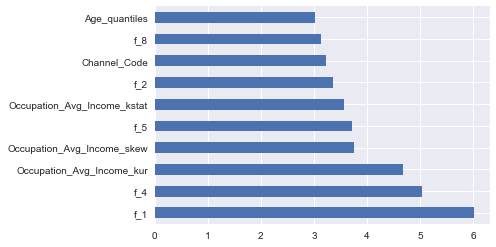

In [132]:
feat_importance_catboost=pd.Series(catboost.feature_importances_,index=train.columns)
feat_importance_catboost.nlargest(10).plot(kind='barh')

<h1>XGBOOST</h1>

In [133]:
xgboost=XGBClassifier(n_estimators=20000,
                      max_depth=6,
                      learning_rate=0.0201,
                      reg_lambda=29.326,
                      subsample=0.818,
                      colsample_bytree=0.235,
                     colsample_bynode=0.820,
                     colsample_bylevel=0.453)
xgboost.fit(X_train_minmax,y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:21:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.453,
              colsample_bynode=0.82, colsample_bytree=0.235, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0201, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20000, n_jobs=12, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=29.326,
              scale_pos_weight=1, subsample=0.818, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [134]:
roc_auc_score(y_train,xgboost.predict_proba(X_train_minmax)[:,1])

0.8909052134999623

In [135]:
roc_auc_score(y_valid,xgboost.predict_proba(X_valid_minmax)[:,1])

0.7712954193782146

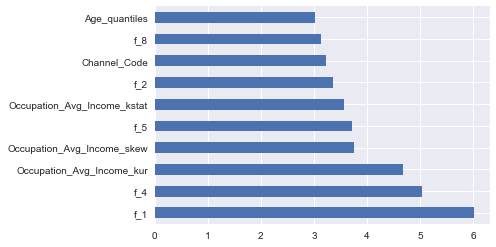

In [136]:
feat_importance_xgboost=pd.Series(xgboost.feature_importances_,index=train.columns)


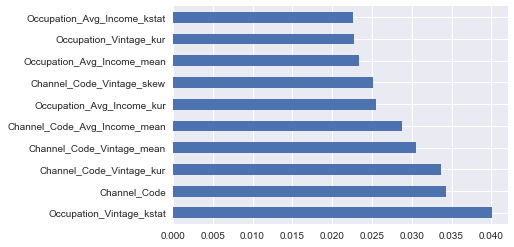

In [140]:
feat_importance_xgboost.nlargest(10).plot(kind='barh')

In [151]:
train_imp_xgboost=train[['Occupation_Vintage_kstat','Channel_Code','Channel_Code_Vintage_kur','Channel_Code_Vintage_mean','Channel_Code_Avg_Income_mean']]

In [152]:
test_imp_xgboost=test[['Occupation_Vintage_kstat','Channel_Code','Channel_Code_Vintage_kur','Channel_Code_Vintage_mean','Channel_Code_Avg_Income_mean']]

In [153]:
# 20% data as validation set
X_train,X_valid,y_train,y_valid = train_test_split(train_imp_xgboost,y,test_size=0.2,random_state=22,stratify=y)

In [154]:
transformer = MaxAbsScaler().fit(X_train)
X_train_minmax= transformer.transform(X_train)
X_valid_minmax = transformer.transform(X_valid)

In [150]:
xgboost=XGBClassifier(n_estimators=10000,
                      max_depth=8,
                      learning_rate=0.0201,
                      reg_lambda=29.326,
                      subsample=0.818,
                      colsample_bytree=0.235,
                     colsample_bynode=0.820,
                     colsample_bylevel=0.453)
xgboost.fit(train_minmax,y)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:17:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.453,
              colsample_bynode=0.82, colsample_bytree=0.235, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0201, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=12, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=29.326,
              scale_pos_weight=1, subsample=0.818, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [151]:
prediction_xgboost=xgboost.predict_proba(test_minmax)[:,1]

In [153]:
prediction_xgboost

array([0.04560902, 0.36950904, 0.08066624, ..., 0.05721048, 0.26389927,
       0.03189079], dtype=float32)

In [157]:
lgbm=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.045, max_bin=94,
               max_depth=8, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=10,
               objective=None, random_state=None, reg_alpha=6.853,
               reg_lambda=0.0, silent=True, subsample=0.749,
               subsample_for_bin=200000, subsample_freq=0)

lgbm.fit(train_minmax,y)

LGBMClassifier(learning_rate=0.045, max_bin=94, max_depth=8, n_estimators=10000,
               num_leaves=10, reg_alpha=6.853, subsample=0.749)

In [158]:
prediction_lgbm=lgbm.predict_proba(test_minmax)[:,1]

In [160]:
prediction_lgbm

array([0.05801732, 0.41274429, 0.05504889, ..., 0.0771643 , 0.20479039,
       0.04775665])

In [185]:
temp=df['Is_Lead'].to_numpy()

In [186]:
temp

array([0.07222545, 0.33590173, 0.05597375, ..., 0.0965056 , 0.21485985,
       0.05222151])

In [187]:
prediction_lgbm

array([0.05801732, 0.41274429, 0.05504889, ..., 0.0771643 , 0.20479039,
       0.04775665])

In [188]:
df=pd.read_csv('sample_submission_eyYijxG.csv')

In [189]:
avg=(temp+prediction_lgbm)/2

In [190]:
df['Is_Lead']=avg

In [191]:
df.to_csv('sample_submission_eyYijxG.csv',index=False)